In [1]:
%%capture
#from jupyterthemes import jtplot
#jtplot.style()
import numpy as np
import operator
import seaborn as sns; sns.set()
from landlab import FieldError
from landlab.utils import get_watershed_mask
import xarray as xr
import pandas as pd
import scipy
import gdal
from scipy import ndimage
from scipy.ndimage.filters import *
import os
import math
from osgeo import osr
from fractions import Fraction
import timeit
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
#import matplotlib.image as mpimg
%matplotlib inline
import random
# import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl
from landlab.plot.imshow import imshow_grid 

# import necessary landlab components
from landlab import RasterModelGrid, HexModelGrid
from landlab.components import FlowAccumulator, LakeMapperBarnes, SinkFillerBarnes
from landlab.components import(FlowDirectorD8, 
                               FlowDirectorDINF, 
                               FlowDirectorMFD, 
                               FlowDirectorSteepest)
from landlab.components import DepressionFinderAndRouter
# import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot
from pylab import show, figure
from scipy.ndimage import gaussian_filter
from statsmodels.formula.api import ols
from scipy.stats import t
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from landlab.utils.flow__distance import calculate_flow__distance
from landlab.utils import watershed
from scipy.odr import *

In [2]:
def rectangleWindow(m, n):
    """Takes a value for number of rows (m) and number of columns (n) such that
       m and n are both positive real numbers and creates a rectangle of 
       boolian 'True' values."""
    rectangle = np.ones((m, n), dtype=bool) 
    return rectangle
def PCTL(x):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = x[central_value]                        
    y = np.sum(x < centroid)/num_values#Count number of values greater than centroid value
    return y
def number_of_values(Window):
    """This funciton takes the shape function as an input and returns a number 
        of values present in the specified shape. 
        
        This can be different for a different window shape and to initialize
        requires the specification of the function for the given window type and 
        parameter values required for that input function.
        
        To initialize this function for shape == rectangle type 'number_of_values(rectangleWindow(m,n)) 
        where m and n are any positive real number as per the rectangleWindow function."""
    denominator = sum(sum(Window > 0))
    return denominator
def slopeWindow(DEM_slope, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM_slope[0]; b = DEM_slope[1]; c = DEM_slope[2]
    d = DEM_slope[3]; e = DEM_slope[4]; f = DEM_slope[5]
    g = DEM_slope[6]; h = DEM_slope[7]; i = DEM_slope[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_percent = rise_run * 100
    #Can also ask it to return slope_degrees but askinh for both causes it to throw and error.
    return slope_percent
def slopeWindowDegrees(DEM, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM[0]; b = DEM[1]; c = DEM[2]
    d = DEM[3]; e = DEM[4]; f = DEM[5]
    g = DEM[6]; h = DEM[7]; i = DEM[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_percent = rise_run * 100
    #Can also ask it to return slope_degrees but asking for both causes it to throw and error.
    return slope_degrees
def slopeWindowMperM(DEM, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM[0]; b = DEM[1]; c = DEM[2]
    d = DEM[3]; e = DEM[4]; f = DEM[5]
    g = DEM[6]; h = DEM[7]; i = DEM[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_m_per_m = rise_run
    #Can also ask it to return slope_degrees but asking for both causes it to throw and error.
    return slope_m_per_m
def planCurvature(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
    systems, Page 284)."""
    Z1 = DEM[0]; Z2 = DEM[1]; Z3 = DEM[2]
    Z4 = DEM[3]; Z0 = DEM[4]; Z5 = DEM[5]
    Z6 = DEM[6]; Z7 = DEM[7]; Z8 = DEM[8]
    D = (((Z4 + Z5)/2) - Z0) / cellsize**2
    E = (((Z2 + Z7)/2) - Z0) / cellsize**2
    F = (Z3 - Z1 + Z6 - Z8)/ (4 * cellsize**2)
    G = (Z5 - Z4) / (2 * cellsize)
    H = (Z2 - Z7) / (2 * cellsize)
    plan_curvature = 2 * ((D*H**2 + E*G**2 - F*G*H) / (G**2 + H**2))
    return plan_curvature
def profileCurvature(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
       systems, Page 284)."""
    Z1 = DEM[0]; Z2 = DEM[1]; Z3 = DEM[2]
    Z4 = DEM[3]; Z0 = DEM[4]; Z5 = DEM[5]
    Z6 = DEM[6]; Z7 = DEM[7]; Z8 = DEM[8]
    D = (((Z4 + Z5)/2) - Z0) / cellsize**2
    E = (((Z2 + Z7)/2) - Z0) / cellsize**2
    F = (Z3 - Z1 + Z6 - Z8)/ (4 * cellsize**2)
    G = (Z5 - Z4) / (2 * cellsize)
    H = (Z2 - Z7) / (2 * cellsize)
    profile_curvature = -2 * (D*G**2 + E*H**2 + F*G*H) / (G**2 + H**2)
    return profile_curvature
def circleWindow(radius):
    """Takes a value for radius (r where r is any positive real number) and creates 
       a circular window using that radius."""
    y, x = np.ogrid[-radius: radius + 1, -radius: radius + 1]
    circle = x**2 + y**2 <= radius**2
    return circle
def find_median_value(Window):
    """This function takes the shape function and returns the median value 
        for all valid values (values that fall in the circle) arranged into a 
        1d array. The function also takes the number_of_values function as an input.
        To execute this function type 'find_median_value(shape(r)) where r is any integer.
        #Note: using median like this only gives the correct value for circles with odd 
        radius values."""
    no_values = number_of_values(Window)
    value_range = np.arange(0, no_values + 1)
    central_value = int(np.median(value_range))
    return central_value
def differenceFromMeanElevation(elev):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = elev[central_value]                        
    mean = np.nanmean(elev)#Count number of values greater than centroid value
    diff = centroid - mean
    return diff
def ghFilter(gully_heads):
    """Reduce the number of candidate initial gully heads. The window size is custimizable through the 
    'footprint' argument. """
    surrounding_nodes_list = [];
    for i in range(0, num_values):
        if i != central_value:
            surrounding_nodes_list.append(gully_heads[i])
    
    surrounding_nodes_array = np.array(surrounding_nodes_list)
    non_zero_values = surrounding_nodes_array[surrounding_nodes_array > 0]
    if non_zero_values.size == 0:
        new_value = 0  
    else:
        if gully_heads[central_value] > 0 and np.min(non_zero_values) > gully_heads[central_value]:
            new_value = 1
        else:
            new_value = 0

    return new_value
def roundup(x):
    return int(math.ceil(x / 10.0)) * 10
def catchmentDicts(area_grid, gn, gh_nodes):
    """Creates a dictionary of node ID:catcment area values."""
    area_dict = {}
    nodes = gh_nodes
    x_axis_length = gn.shape[1]
    for i in nodes:
        row = int(np.floor(i / x_axis_length))
        col = int(i - (row*x_axis_length))
        area = area_grid[row,col]
        area_dict[i] = area
    return area_dict
def upslopeDivergence(catchment_area_list, change_detection_factor, step_size, comparison_distance):
    
    """"Looks at whether catchment area is increasing at any point upstream of a gully head.
    
    - 'catchment_area_list' is an ordered list of node catchment areas moving upstream.
    
    - 'change_detection_factor' is the percentage increase required for the function to consider the change
    to represent a point of divergent flow.
    
    - 'step_size' is the number of grid cells to be compared in downstream to upstream groups. E.g. step_size == 1 
    will compare node 1 and node 2, but step_size == 2 will compare node 1 and 2 to node 3 and 4.
    
    - 'comparison_distance' is the distance between the downstream nodes being compared to upstream nodes."""
    
    max_value_length = len(catchment_area_list) - step_size - comparison_distance - step_size
    for i in range(0, max_value_length):
                
        start_of_downstream_nodes = i
        end_of_downstream_nodes = i + step_size       
        downstream_nodes = catchment_area_list[start_of_downstream_nodes:end_of_downstream_nodes]
        
        start_of_upstream_nodes = i + step_size + comparison_distance
        end_of_usptreat_nodes = start_of_upstream_nodes + step_size
        upstream_nodes = catchment_area_list[start_of_upstream_nodes:end_of_usptreat_nodes]
        
        required_catchment_area_increase = max(downstream_nodes) + (max(downstream_nodes) * change_detection_factor)
        
        if all(nodes >= required_catchment_area_increase for nodes in upstream_nodes):
            divergence = 1
            break
        else:
            divergence = 0
    return divergence
def findGullyHeadNode(gully_heads, grid_nodes, DEM, ca, input_DEM_resolution, 
                      distance_from_node, contributing_fraction, required_ca):
    
    catchment_area_dict = {}
    catchment_area_node_list = []
    distance_from_node = int(np.ceil(distance_from_node/input_DEM_resolution))

    for i in gully_heads:

        result = np.where(grid_nodes == i)
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        #################################################################################################
        # Create a subset based on above. Plus 1 to bottom abnd right so that the currenmmt gully ead node is always the 
        # centraL grid node of the subset.
        subset_row_top = int(row_index - distance_from_node)
        subset_row_bot = int(row_index + distance_from_node) + 1
        subset_col_left = int(col_index - distance_from_node)
        subset_col_right = int(col_index + distance_from_node) + 1
        #################################################################################################
        # Restrict the size of the subset in cases where it is on the edge of a DEM.
        subset_row_top_adjusted = max(subset_row_top, 0);
        subset_row_bot_adjusted = min(subset_row_bot, DEM.shape[0]);
        subset_col_left_adjusted = max(subset_col_left, 0);
        subset_col_right_adjusted = min(subset_col_right, DEM.shape[1]);
        #################################################################################################
        # Find the offset required by restricting the size of the subset around DEM edges.
        # This offset is needed to find the new location of the current gully head grid cell (no longer center of the subset).
        offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
        offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
        offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
        offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));
        #################################################################################################
        # Create subset around the current gully head grid node. 
        dem_subset = DEM[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]

        #################################################################################################
        ca_subset = ca[subset_row_top_adjusted:subset_row_bot_adjusted, 
                             subset_col_left_adjusted:subset_col_right_adjusted]
        print('max ca: ', np.amax(ca_subset))
        #################################################################################################
        # Find the latitude and longitude index positions of the gully head node in the subset DEM.
        node_lat = distance_from_node + offset_row_top
        node_lon = distance_from_node + offset_col_left
        #################################################################################################  
        # Run M8 for the subset DEM.
        flow_acc_surf_sub = np.copy(dem_subset).astype('float64');

        rows_sub = flow_acc_surf_sub.shape[0];
        cols_sub = flow_acc_surf_sub.shape[1];
        mg1 = RasterModelGrid((rows_sub,cols_sub), 1);
        z1 = mg1.add_field('topographic__elevation', flow_acc_surf_sub, at = 'node');
        sfb = SinkFillerBarnes(mg1, method = 'Steepest', ignore_overfill = True);
        sfb.run_one_step();
        fa = FlowAccumulator(mg1,
                            surface = 'topographic__elevation',
                            flow_director = 'FlowDirectorMFD',
                            diagonals = True);
        fa.run_one_step()
        fd = FlowDirectorMFD(mg1, 'topographic__elevation', diagonals = True);
        fd.run_one_step()
        #################################################################################################
        # Extract required grid properties
        da = np.array(mg1.at_node['drainage_area'].round(4)); # Drainage area.
        frn = mg1.at_node['flow__receiver_node'];# Flow receiver nodes.
        drainage_area = da.reshape(mg1.shape);
        frp = np.array(mg1.at_node['flow__receiver_proportions']);# Flow receiver proportions
        flow_rec_surf_rows = cols_sub * rows_sub;
        flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);
        all_receiver_proportions = np.copy(frp);
        grid_nodes_sub = np.array(mg1.nodes.reshape(mg1.shape));
        #################################################################################################
        central_node = grid_nodes_sub[node_lat, node_lon]
        # Specific the size of the area to be checked. This represents a physical distance from the 
        # outlet but has no unit of measure. Its maximum size is the size of the 'distance_from_node' variable.

        # This value is used to initialise the search.
        catchment_outlet_id = central_node

        # Initate an outer loop that iterates through every distance interval from the outlet. Each iteration checks whether 
        # an area equal to the 'contributing_fraction' variable below is being directed in only one direction (converging).
        # Otherwise it moves to the nect grid cell downslope in the direction of steepest slope.

        # Create a grid of node value sfor the subset DEM.
        node_location = mg1.nodes.reshape(da.shape);
        for j in range(0, distance_from_node):
            # Begin at the point (node) digitized as the intersection between the central flow line and the gully head.
            if j == 0:
                candidate_gridcell = catchment_outlet_id;
            else:
                candidate_gridcell = next_cell_downstream;
            # Get all receiver nodes of the current node.
            grid_cell_receiver_nodes = frp[candidate_gridcell,:];
            # Check if there is a node that receives >= 'contributing_fraction' from the current node.
            candidate_gridcell_list = [candidate_gridcell]
            node_ca_int = catchmentDicts(ca_subset, grid_nodes_sub, candidate_gridcell_list) # Find the node's contributing area.
            node_ca = node_ca_int[candidate_gridcell]
            print('Node id: ', candidate_gridcell, 'Catchment area: ', node_ca)
            if np.amax(grid_cell_receiver_nodes) < contributing_fraction or node_ca < required_ca:
                # Check if this is the last possible grid cell in the subset that could meet the criteria. If so, then there
                # is no suitable grid cell (node).
                if j == distance_from_node - 1:
                    catchment_area_dict[i] = 'No grid cell found'
                else:
                    # Otherwise, find the next downslope grid cell receiving the highest proportion of flow and check that 
                    # in the next iteration.
                    index_next_cell_downstream = np.where(grid_cell_receiver_nodes == np.amax(grid_cell_receiver_nodes))[0][0];
                    next_cell_downstream = frn[candidate_gridcell, index_next_cell_downstream];
            else:
                # Find the position of the gridcell (node) that meets the criteria both in the subset and in the whole DEM
                # and record the node ID.
                final_node_index_lat =  np.where(grid_nodes_sub == candidate_gridcell)[0][0]
                final_node_index_lon =  np.where(grid_nodes_sub == candidate_gridcell)[1][0]
                
                # Find the offest between the index position of the node the loop ends on, and the index position of
                # the node that it started on. 
                final_lat_offset = final_node_index_lat - node_lat
                final_lon_offset = final_node_index_lon - node_lon
                # Then apply this offest to the index position of the starting node with respect top the whole DEM to find the 
                # node ID of the grid cell that met the criteria above.
                final_row_index = row_index + final_lat_offset
                final_col_index = col_index + final_lon_offset
                node_of_area_record = grid_nodes[final_row_index, final_col_index] # - this range is more than 1
                catchment_area_dict[i] = node_of_area_record
                catchment_area_node_list.append(node_of_area_record)
                break
                             
    return catchment_area_dict, catchment_area_node_list
def findPoint5mDownstream(gully_heads, grid_nodes, DEM, ca, input_DEM_resolution, 
                      distance_from_node):
    
    catchment_area_dict = {}
    catchment_area_node_list = []
    distance_from_node = int(np.ceil(distance_from_node/input_DEM_resolution))

    for i in gully_heads:

        result = np.where(grid_nodes == i)
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        #################################################################################################
        # Create a subset based on above. Plus 1 to bottom abnd right so that the currenmmt gully ead node is always the 
        # centraL grid node of the subset.
        subset_row_top = int(row_index - distance_from_node)
        subset_row_bot = int(row_index + distance_from_node) + 1
        subset_col_left = int(col_index - distance_from_node)
        subset_col_right = int(col_index + distance_from_node) + 1
        #################################################################################################
        # Restrict the size of the subset in cases where it is on the edge of a DEM.
        subset_row_top_adjusted = max(subset_row_top, 0);
        subset_row_bot_adjusted = min(subset_row_bot, DEM.shape[0]);
        subset_col_left_adjusted = max(subset_col_left, 0);
        subset_col_right_adjusted = min(subset_col_right, DEM.shape[1]);
        #################################################################################################
        # Find the offset required by restricting the size of the subset around DEM edges.
        # This offset is needed to find the new location of the current gully head grid cell (no longer center of the subset).
        offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
        offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
        offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
        offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));
        #################################################################################################
        # Create subset around the current gully head grid node. 
        dem_subset = DEM[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]

        #################################################################################################
        ca_subset = ca[subset_row_top_adjusted:subset_row_bot_adjusted, 
                             subset_col_left_adjusted:subset_col_right_adjusted]
        print('max ca: ', np.amax(ca_subset))
        #################################################################################################
        # Find the latitude and longitude index positions of the gully head node in the subset DEM.
        node_lat = distance_from_node + offset_row_top
        node_lon = distance_from_node + offset_col_left
        #################################################################################################  
        # Run M8 for the subset DEM.
        flow_acc_surf_sub = np.copy(dem_subset).astype('float64');

        rows_sub = flow_acc_surf_sub.shape[0];
        cols_sub = flow_acc_surf_sub.shape[1];
        mg1 = RasterModelGrid((rows_sub,cols_sub), 1);
        z1 = mg1.add_field('topographic__elevation', flow_acc_surf_sub, at = 'node');
        sfb = SinkFillerBarnes(mg1, method = 'Steepest', ignore_overfill = True);
        sfb.run_one_step();
        fa = FlowAccumulator(mg1,
                            surface = 'topographic__elevation',
                            flow_director = 'FlowDirectorMFD',
                            diagonals = True);
        fa.run_one_step()
        fd = FlowDirectorMFD(mg1, 'topographic__elevation', diagonals = True);
        fd.run_one_step()
        #################################################################################################
        # Extract required grid properties
        da = np.array(mg1.at_node['drainage_area'].round(4)); # Drainage area.
        frn = mg1.at_node['flow__receiver_node'];# Flow receiver nodes.
        drainage_area = da.reshape(mg1.shape);
        frp = np.array(mg1.at_node['flow__receiver_proportions']);# Flow receiver proportions
        flow_rec_surf_rows = cols_sub * rows_sub;
        flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);
        all_receiver_proportions = np.copy(frp);
        grid_nodes_sub = np.array(mg1.nodes.reshape(mg1.shape));
        #################################################################################################
        central_node = grid_nodes_sub[node_lat, node_lon]
        # Specific the size of the area to be checked. This represents a physical distance from the 
        # outlet but has no unit of measure. Its maximum size is the size of the 'distance_from_node' variable.

        # This value is used to initialise the search.
        catchment_outlet_id = central_node

        # Initate an outer loop that iterates through every distance interval from the outlet. Each iteration checks whether 
        # an area equal to the 'contributing_fraction' variable below is being directed in only one direction (converging).
        # Otherwise it moves to the nect grid cell downslope in the direction of steepest slope.

        # Create a grid of node value sfor the subset DEM.
        node_location = mg1.nodes.reshape(da.shape);
        for j in range(0, distance_from_node):
            # Begin at the point (node) digitized as the intersection between the central flow line and the gully head.
            if j == 0:
                candidate_gridcell = catchment_outlet_id;
            else:
                candidate_gridcell = next_cell_downstream;
            # Get all receiver nodes of the current node.
            grid_cell_receiver_nodes = frp[candidate_gridcell,:];
            # Check if there is a node that receives >= 'contributing_fraction' from the current node.
            candidate_gridcell_list = [candidate_gridcell]
            node_ca_int = catchmentDicts(ca_subset, grid_nodes_sub, candidate_gridcell_list) # Find the node's contributing area.
            node_ca = node_ca_int[candidate_gridcell]
            print('Node id: ', candidate_gridcell, 'Catchment area: ', node_ca)
            if j + 1 < distance_from_node:
                
                # Otherwise, find the next downslope grid cell receiving the highest proportion of flow and check that 
                # in the next iteration.
                index_next_cell_downstream = np.where(grid_cell_receiver_nodes == np.amax(grid_cell_receiver_nodes))[0][0];
                next_cell_downstream = frn[candidate_gridcell, index_next_cell_downstream];
            else:
                print(j)
                # Find the position of the gridcell (node) that meets the criteria both in the subset and in the whole DEM
                # and record the node ID.
                final_node_index_lat =  np.where(grid_nodes_sub == candidate_gridcell)[0][0]
                final_node_index_lon =  np.where(grid_nodes_sub == candidate_gridcell)[1][0]
                
                # Find the offest between the index position of the node the loop ends on, and the index position of
                # the node that it started on. 
                final_lat_offset = final_node_index_lat - node_lat
                final_lon_offset = final_node_index_lon - node_lon
                # Then apply this offest to the index position of the starting node with respect top the whole DEM to find the 
                # node ID of the grid cell that met the criteria above.
                final_row_index = row_index + final_lat_offset
                final_col_index = col_index + final_lon_offset
                node_of_area_record = grid_nodes[final_row_index, final_col_index] # - this range is more than 1
                catchment_area_dict[i] = node_of_area_record
                catchment_area_node_list.append(node_of_area_record)
                break
                             
    return catchment_area_dict, catchment_area_node_list
def closest(lst, K): 
     angle_list = lst
     index_pos = (np.abs(angle_list - K)).argmin() 
     return angle_list[index_pos]  
def data_range(data):
    data_min = np.amin(data); data_max = np.amax(data)
    value_range = data_max - data_min
    return value_range
def checkGullyHead(dfme_list, step_size, comparison_distance, minimum_depth, elevation_of_gh):
    
    """ """
    max_value_length = len(dfme_list) - step_size - comparison_distance - step_size
    for i in range(0, max_value_length):
                
        start_of_downstream_nodes = i
        end_of_downstream_nodes = i + step_size       
        downstream_nodes = dfme_list[start_of_downstream_nodes:end_of_downstream_nodes]
        
        start_of_upstream_nodes = i + step_size + comparison_distance
        end_of_usptreat_nodes = start_of_upstream_nodes + step_size
        upstream_nodes = dfme_list[start_of_upstream_nodes:end_of_usptreat_nodes]
        
        min_downstream = np.min(downstream_nodes)
        mean_upstream = np.mean(upstream_nodes)
        std_upstream = np.std(upstream_nodes)
        elevation_difference = min_downstream - mean_upstream
        print('minimum downstream value: ', min_downstream)
        print('mean upstream value: ', mean_upstream)
        print('std upstream value: ', std_upstream)
      
        if min_downstream <= minimum_depth and mean_upstream > elevation_of_gh and std_upstream < 0.1 and elevation_difference <= -0.3:
            keep_gully = 'yes'
            # below could use either floor or ceil instead of round 
            gully_head_location = int(end_of_downstream_nodes + np.round(comparison_distance/2))
            break
        else:
            keep_gully = 'no'
            gully_head_location = 'none'

    return keep_gully, gully_head_location
def upstreamDrainageLine(meters_from_gully_head, input_DEM_resolution, grid_nodes, DEM, import_drainage_area, 
                         import_dfme, catchment_outlet_ids, step_size_m, comparison_distance_m,  
                         min_depth, gh_elevation):
    
    """This function works its way up the hillslope from a gully head recording 
    catchment area at each grid cell along the way. Then for each gully head it assesses whether divergence is occuring 
    at any point by using the upslopeDivergence function.
    
    meters_from_gully_head == distance upstream from gully head in meters.
    input_DEM_resolution == grid resolution of the input DEM.
    frn == flow receiver nodes stored on the model grid object.
    catchment_outlet_ids == a list of grid cells found using the estimateCatchmentArea function.
    drainage_area == drainage area stored on the model grid object.
    grid_nodes == grid node values stored on the model grid object.
    DEM == initial input_DEM
    step_size_m and comparison_distance_m are both enetered in meters and are then adjusted automatically
    to fit the resolution.
    slope_above_head == the distance from the convergence point that slope is taken."""
    
    final_gully_head_position_dict = {}
    catchment_area_node_list = []
    distance_from_node = int(meters_from_gully_head / input_DEM_resolution)
    is_gully_head = {}

    step_size = int(np.round(step_size_m / input_DEM_resolution))
    comparison_distance = int(np.round(comparison_distance_m / input_DEM_resolution))
    gully_head_node_dict = {}
    for i in catchment_outlet_ids:
        
        result = np.where(grid_nodes == i)
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        #################################################################################################
        # Create a subset based on above. Plus 1 to bottom abnd right so that the currenmmt gully ead node is always the 
        # centraL grid node of the subset.
        subset_row_top = int(row_index - distance_from_node)
        subset_row_bot = int(row_index + distance_from_node) + 1
        subset_col_left = int(col_index - distance_from_node)
        subset_col_right = int(col_index + distance_from_node) + 1
        #################################################################################################
        # Restrict the size of the subset in cases where it is on the edge of a DEM.
        subset_row_top_adjusted = max(subset_row_top, 0);
        subset_row_bot_adjusted = min(subset_row_bot, DEM.shape[0]);
        subset_col_left_adjusted = max(subset_col_left, 0);
        subset_col_right_adjusted = min(subset_col_right, DEM.shape[1]);
        #################################################################################################
        # Find the offset required by restricting the size of the subset around DEM edges.
        # This offset is needed to find the new location of the current gully head grid cell (no longer center of the subset).
        offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
        offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
        offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
        offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));
        #################################################################################################
        # Create subset around the current gully head grid node. 
        dem_subset_copy = np.copy(DEM);
        dem_subset = dem_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]
        
        #################################################################################################
        # Find the latitude and longitude index positions of the gully head node in the subset DEM.
        node_lat = distance_from_node + offset_row_top
        node_lon = distance_from_node + offset_col_left
        #################################################################################################  
        # Run M8 for the subset DEM.
        flow_acc_surf_sub = np.copy(dem_subset).astype('float64');
        rows_sub = flow_acc_surf_sub.shape[0];
        cols_sub = flow_acc_surf_sub.shape[1];
        mg1 = RasterModelGrid((rows_sub,cols_sub), 1);
        z1 = mg1.add_field('topographic__elevation', flow_acc_surf_sub, at = 'node');

        sfb = SinkFillerBarnes(mg1, method = 'Steepest', ignore_overfill = True);
        sfb.run_one_step();
        fa = FlowAccumulator(mg1,
                            surface = 'topographic__elevation',
                            flow_director = 'FlowDirectorMFD',
                            diagonals = True);

        fa.run_one_step()
        fd = FlowDirectorMFD(mg1, 'topographic__elevation', diagonals = True);
        fd.run_one_step()
        #################################################################################################
        # Extract required grid properties
        da = np.array(mg1.at_node['drainage_area'].round(4)); # Drainage area.
        
        #da_subset_copy = np.copy(import_drainage_area)
        import_da_subset = import_drainage_area[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]

        flattened_import_da = import_da_subset.reshape(da.shape)
        
        #dfme_subset_copy = np.copy(import_dfme)
        import_dfme_subset = import_dfme[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]
        flattened_import_dfme = import_dfme_subset.reshape(da.shape)
        
        grid_nodes_subset = grid_nodes[subset_row_top_adjusted:subset_row_bot_adjusted, 
                             subset_col_left_adjusted:subset_col_right_adjusted]
        
        flattened_grid_nodes_subset = grid_nodes_subset.reshape(da.shape)
        
        frn = mg1.at_node['flow__receiver_node'];# Flow receiver nodes.

        frp = np.array(mg1.at_node['flow__receiver_proportions']);# Flow receiver proportions
        flow_rec_surf_rows = cols_sub * rows_sub;
        flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);
        all_receiver_proportions = np.copy(frp);
        grid_nodes_sub = np.array(mg1.nodes.reshape(mg1.shape));
        #################################################################################################
        central_node = grid_nodes_sub[node_lat, node_lon]
        print(central_node)
        print(mg1.shape)
        # Specific the size of the area to be checked. This represents a physical distance from the 
        # outlet but has no unit of measure. Its maximum size is the size of the 'distance_from_node' variable.       

        # This value is used to initialise the search.
        catchment_outlet_id = central_node

        # Initate an outer loop that iterates through every distance interval from the outlet. Each iteration checks whether 
        # an area equal to the 'contributing_fraction' variable below is being directed in only one direction (converging).
        # Otherwise it moves to the nect grid cell downslope in the direction of steepest slope.

        # Create a grid of node value sfor the subset DEM.
        node_location = mg1.nodes.reshape(da.shape);
        node_area_dict = {}
        node_dfme_dict = {}
        original_node_id_dict = {}
        # This value is used to initialise the search.
        # Initate an outer loop that iterates through every distance interval from the outlet.
        watershed_grid_cells = []
        ordered_node_list = []

        for d in range(0, distance_from_node):
            # Just look at watershed grid cells here.
            # Create a list initially containing only the outlet grid cell.
            if d == 0:
                candidate_gridcells = [catchment_outlet_id];
            else:
                candidate_gridcells = list(set(upstream_nodes));
            # Empty the list of upsteam nodes.
            upstream_node_dict = {};
            upstream_dfme_dict = {};
            upstream_original_node_id = {}
            # Intiate a new loop to check every gridcell at the current interval distance.
            for grid_cell in candidate_gridcells:
                # Check each flow direction of the current grid cell.The second dimension of the 
                # flow__receiver_node object will always be size == 8.
                for j in range(frn.shape[1]):
                    # Return all rows (grid nodes) that send any flow to the target grid cell.
                    # Note: This can only be one grid cell because the prgram is looping through
                    # each direction one at a time so only one grid cell can be sending flow from any
                    # one given direction.
                    flow_from_whole_grid_cell = frn[np.where(frn[:,j] == grid_cell)];
                    # Check if the current direction contributes flow. If not, do nothing. 
                    # Else, append to dictionary.
                    if flow_from_whole_grid_cell.shape[0] == 0:
                        pass
                    else:
                        # Below variable finds the row position of the flow_from_direction gridcell
                        # in the flow__receiver_node array. This corresponds to the contributing
                        # cell's node id.
                        node_id_value = np.where(np.all(flow_from_whole_grid_cell==frn,axis=1))[0][0];
                        #Find the proportion of flow leaving the donor node and heading toward 
                        # the current grid cell.
                        proportion_of_flow = frp[node_id_value, j]
                        # Create a boolean array to use as mask on drainage area.
                        isolate_candidate_grid_cells = np.isin(node_location, node_id_value)
                        node_drainage_area = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_import_da))
                        node_directional_drainage_area = node_drainage_area * proportion_of_flow
                        upstream_node_dict.update({node_id_value:node_directional_drainage_area});
                        original_node_id = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_grid_nodes_subset))
                        upstream_original_node_id.update({node_id_value:original_node_id})
                        node_dfme = np.amin(np.multiply(isolate_candidate_grid_cells, flattened_import_dfme))
                        upstream_dfme_dict.update({node_id_value:node_dfme})

                if len(upstream_node_dict) == 0:
                    pass
                else:
                    primary_flow_direction_id = max(upstream_node_dict.items(), key=operator.itemgetter(1))[0]
                    upstream_nodes = []
                    upstream_nodes.append(primary_flow_direction_id);
                    ordered_node_list.append(primary_flow_direction_id);
                    print(primary_flow_direction_id)
                    watershed_grid_cells.append(primary_flow_direction_id);
                    node_area_dict[primary_flow_direction_id] = upstream_node_dict[primary_flow_direction_id]

                    node_dfme_dict[primary_flow_direction_id] = upstream_dfme_dict[primary_flow_direction_id]
                    original_node_id_dict[primary_flow_direction_id] = upstream_original_node_id[primary_flow_direction_id]
                    distance_in_meters = int(d*input_DEM_resolution)

                    
        dfme_along_central_drainage_line = []
        for key, value in node_dfme_dict.items():
            dfme_along_central_drainage_line.append(value)
        median_dfme_along_central_drainage_line = ndimage.median_filter(dfme_along_central_drainage_line, size=step_size_m)
        
        original_node_id_along_central_drainage_line = []
        for key, value in original_node_id_dict.items():
            original_node_id_along_central_drainage_line.append(value)
        
        required_number_of_grid_cells = step_size + comparison_distance + step_size + 1
        if len(median_dfme_along_central_drainage_line) < required_number_of_grid_cells:
            is_gully_head[i] = 'not enough grid cells'
        else:
            print('node: ',i,)
            divergence_occuring, gully_head_node = checkGullyHead(dfme_along_central_drainage_line, 
                                                    step_size, comparison_distance, min_depth, gh_elevation)
            is_gully_head[i] = divergence_occuring
            gully_head_node_dict[i] = gully_head_node
            if isinstance(gully_head_node, str):
                pass
            else:
                final_gully_head_position_dict[i] = original_node_id_along_central_drainage_line[gully_head_node]
                
    return final_gully_head_position_dict, is_gully_head
def checkGullyEdges(dfme_list, step_size, comparison_distance, minimum_depth, elevation_of_edges):
    
    """ """
    max_value_length = len(dfme_list) - step_size - comparison_distance - step_size
    for i in range(0, max_value_length):
                
        start_of_downstream_nodes = i
        end_of_downstream_nodes = i + step_size       
        downstream_nodes = dfme_list[start_of_downstream_nodes:end_of_downstream_nodes]
        
        start_of_upstream_nodes = i + step_size + comparison_distance
        end_of_usptream_nodes = start_of_upstream_nodes + step_size
        upstream_nodes = dfme_list[start_of_upstream_nodes:end_of_usptream_nodes]
        
        min_downstream = np.min(downstream_nodes)
        mean_upstream = np.mean(upstream_nodes)
        std_upstream = np.std(upstream_nodes)
        elevation_difference = min_downstream - mean_upstream
        #print('minimum downstream value: ', min_downstream)
        #print('mean upstream value: ', mean_upstream)
        #print('std upstream value: ', std_upstream)
      
        if min_downstream <= minimum_depth and mean_upstream > elevation_of_edges and std_upstream < 0.1 and elevation_difference <= -0.3:
            keep_gully = 'yes'
            # below could use either floor or ceil instead of round 
            gully_head_location = int(start_of_upstream_nodes)
            break
        else:
            keep_gully = 'no'
            gully_head_location = 'none'

    return keep_gully, gully_head_location
def thresholdLine(regression_dataset, area_column_title, slope_column_title):
    cooks_d_cutoff = 4 / len(regression_dataset)

    regression_dataset['log_area'] = np.log10(regression_dataset[area_column_title])
    regression_dataset['log_slope'] = np.log10(regression_dataset[slope_column_title])

    m = ols('log_slope ~ log_area',regression_dataset).fit()
    r_intercept = m.params[0]
    r_slope = m.params[1]

    above_model_line = []

    for j in regression_dataset.index:
        measured_slope = regression_dataset['log_slope'].loc[j]
        model_slope = r_slope * regression_dataset['log_area'].loc[j] + r_intercept
        if  measured_slope > model_slope:
            above_model_line.append(j)
        else:
            pass

    corrected_set = regression_dataset.drop(above_model_line, axis='index')

    if len(corrected_set) < 3:
        slope = 'not enough data'
        intercept = 'not enough data'
        pass
    else:
        lowest_points_m = ols('log_slope ~ log_area',corrected_set).fit()
        infl = lowest_points_m.get_influence()

        sm_fr = infl.summary_frame()
        if np.any(sm_fr['cooks_d'] > cooks_d_cutoff):
            high_value_list = sm_fr.index[sm_fr['cooks_d'] > cooks_d_cutoff].tolist()
            final_corrected_set = corrected_set.drop(high_value_list, axis='index')

        else:
            final_corrected_set = corrected_set
        if len(final_corrected_set) < 3:
            slope = 'not enough data'
            intercept = 'not enough data'
            pass
        else:
            final_m = ols('log_slope ~ log_area',final_corrected_set).fit()
            l_intercept = final_m.params[0]
            l_slope = final_m.params[1]

            intercept = 10**l_intercept

            slope = l_slope * -1
            
    return l_slope, l_intercept, slope, intercept, final_corrected_set
def upstreamSlope(meters_from_gully_head, input_DEM_resolution, grid_nodes, DEM, import_drainage_area, 
                         import_dfme, catchment_outlet_ids, step_size_m, comparison_distance_m,  
                         slope_above_head, min_depth, gh_elevation):
    
    """This function works its way up the hillslope from a gully head recording 
    catchment area at each grid cell along the way. Then for each gully head it assesses whether divergence is occuring 
    at any point by using the upslopeDivergence function.
    
    meters_from_gully_head == distance upstream from gully head in meters.
    input_DEM_resolution == grid resolution of the input DEM.
    frn == flow receiver nodes stored on the model grid object.
    catchment_outlet_ids == a list of grid cells found using the estimateCatchmentArea function.
    drainage_area == drainage area stored on the model grid object.
    grid_nodes == grid node values stored on the model grid object.
    DEM == initial input_DEM
    step_size_m and comparison_distance_m are both enetered in meters and are then adjusted automatically
    to fit the resolution.
    slope_above_head == the distance from the convergence point that slope is taken."""
    
    final_gully_head_position_dict = {}
    catchment_area_node_list = []
    distance_from_node = int(meters_from_gully_head / input_DEM_resolution)
    is_gully_head = {}
    slope_dict = {}
    slope_at_head = {}
    
    step_size = int(np.round(step_size_m / input_DEM_resolution))
    comparison_distance = int(np.round(comparison_distance_m / input_DEM_resolution))
    gully_head_node_dict = {}
    for i in catchment_outlet_ids:
        
        result = np.where(grid_nodes == i)
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        #################################################################################################
        # Create a subset based on above. Plus 1 to bottom abnd right so that the currenmmt gully ead node is always the 
        # centraL grid node of the subset.
        subset_row_top = int(row_index - distance_from_node)
        subset_row_bot = int(row_index + distance_from_node) + 1
        subset_col_left = int(col_index - distance_from_node)
        subset_col_right = int(col_index + distance_from_node) + 1
        #################################################################################################
        # Restrict the size of the subset in cases where it is on the edge of a DEM.
        subset_row_top_adjusted = max(subset_row_top, 0);
        subset_row_bot_adjusted = min(subset_row_bot, DEM.shape[0]);
        subset_col_left_adjusted = max(subset_col_left, 0);
        subset_col_right_adjusted = min(subset_col_right, DEM.shape[1]);
        #################################################################################################
        # Find the offset required by restricting the size of the subset around DEM edges.
        # This offset is needed to find the new location of the current gully head grid cell (no longer center of the subset).
        offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
        offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
        offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
        offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));
        #################################################################################################
        # Create subset around the current gully head grid node. 
        dem_subset_copy = np.copy(DEM);
        dem_subset = dem_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]
        
        #################################################################################################
        # Find the latitude and longitude index positions of the gully head node in the subset DEM.
        node_lat = distance_from_node + offset_row_top
        node_lon = distance_from_node + offset_col_left
        #################################################################################################  
        # Run M8 for the subset DEM.
        flow_acc_surf_sub = np.copy(dem_subset).astype('float64');
        rows_sub = flow_acc_surf_sub.shape[0];
        cols_sub = flow_acc_surf_sub.shape[1];
        mg1 = RasterModelGrid((rows_sub,cols_sub), 1);
        z1 = mg1.add_field('topographic__elevation', flow_acc_surf_sub, at = 'node');

        sfb = SinkFillerBarnes(mg1, method = 'Steepest', ignore_overfill = True);
        sfb.run_one_step();
        fa = FlowAccumulator(mg1,
                            surface = 'topographic__elevation',
                            flow_director = 'FlowDirectorMFD',
                            diagonals = True);

        fa.run_one_step()
        fd = FlowDirectorMFD(mg1, 'topographic__elevation', diagonals = True);
        fd.run_one_step()
        #################################################################################################
        # Extract required grid properties
        da = np.array(mg1.at_node['drainage_area'].round(4)); # Drainage area.
        
        #da_subset_copy = np.copy(import_drainage_area)
        import_da_subset = import_drainage_area[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]

        flattened_import_da = import_da_subset.reshape(da.shape)
        
        #dfme_subset_copy = np.copy(import_dfme)
        import_dfme_subset = import_dfme[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]
        flattened_import_dfme = import_dfme_subset.reshape(da.shape)
        
        grid_nodes_subset = grid_nodes[subset_row_top_adjusted:subset_row_bot_adjusted, 
                             subset_col_left_adjusted:subset_col_right_adjusted]
        
        flattened_grid_nodes_subset = grid_nodes_subset.reshape(da.shape)
        
        frn = mg1.at_node['flow__receiver_node'];# Flow receiver nodes.

        frp = np.array(mg1.at_node['flow__receiver_proportions']);# Flow receiver proportions
        flow_rec_surf_rows = cols_sub * rows_sub;
        flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);
        all_receiver_proportions = np.copy(frp);
        grid_nodes_sub = np.array(mg1.nodes.reshape(mg1.shape));
        #################################################################################################
        central_node = grid_nodes_sub[node_lat, node_lon]
        print(central_node)
        print(mg1.shape)
        # Specific the size of the area to be checked. This represents a physical distance from the 
        # outlet but has no unit of measure. Its maximum size is the size of the 'distance_from_node' variable.
        slope = generic_filter(dem_subset, slopeWindowMperM,
                      footprint= rectangleWindow(3,3),
                      mode='constant', extra_arguments = (input_DEM_resolution,input_DEM_resolution,));

        flattened_slope = slope.reshape(da.shape)
        

        # This value is used to initialise the search.
        catchment_outlet_id = central_node

        # Initate an outer loop that iterates through every distance interval from the outlet. Each iteration checks whether 
        # an area equal to the 'contributing_fraction' variable below is being directed in only one direction (converging).
        # Otherwise it moves to the nect grid cell downslope in the direction of steepest slope.

        # Create a grid of node value sfor the subset DEM.
        node_location = mg1.nodes.reshape(da.shape);
        node_area_dict = {}
        slope_mean_dict = {}
        node_dfme_dict = {}
        original_node_id_dict = {}
        # This value is used to initialise the search.
        # Initate an outer loop that iterates through every distance interval from the outlet.
        watershed_grid_cells = []
        ordered_node_list = []

        for d in range(0, distance_from_node):
            target_distance = int(np.floor(slope_above_head/input_DEM_resolution)) 
            # Just look at watershed grid cells here.
            # Create a list initially containing only the outlet grid cell.
            if d == 0:
                candidate_gridcells = [catchment_outlet_id];
            else:
                candidate_gridcells = list(set(upstream_nodes));
            # Empty the list of upsteam nodes.
            upstream_node_dict = {};
            upstream_slope_dict = {};
            upstream_dfme_dict = {};
            upstream_original_node_id = {}
            # Intiate a new loop to check every gridcell at the current interval distance.
            for grid_cell in candidate_gridcells:
                # Check each flow direction of the current grid cell.The second dimension of the 
                # flow__receiver_node object will always be size == 8.
                for j in range(frn.shape[1]):
                    # Return all rows (grid nodes) that send any flow to the target grid cell.
                    # Note: This can only be one grid cell because the prgram is looping through
                    # each direction one at a time so only one grid cell can be sending flow from any
                    # one given direction.
                    flow_from_whole_grid_cell = frn[np.where(frn[:,j] == grid_cell)];
                    # Check if the current direction contributes flow. If not, do nothing. 
                    # Else, append to dictionary.
                    if flow_from_whole_grid_cell.shape[0] == 0:
                        pass
                    else:
                        # Below variable finds the row position of the flow_from_direction gridcell
                        # in the flow__receiver_node array. This corresponds to the contributing
                        # cell's node id.
                        node_id_value = np.where(np.all(flow_from_whole_grid_cell==frn,axis=1))[0][0];
                        #Find the proportion of flow leaving the donor node and heading toward 
                        # the current grid cell.
                        proportion_of_flow = frp[node_id_value, j]
                        # Create a boolean array to use as mask on drainage area.
                        isolate_candidate_grid_cells = np.isin(node_location, node_id_value)
                        node_drainage_area = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_import_da))
                        node_directional_drainage_area = node_drainage_area * proportion_of_flow
                        upstream_node_dict.update({node_id_value:node_directional_drainage_area});
                        node_slope = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_slope))
                        upstream_slope_dict.update({node_id_value:node_slope})
                        original_node_id = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_grid_nodes_subset))
                        upstream_original_node_id.update({node_id_value:original_node_id})
                        node_dfme = np.amin(np.multiply(isolate_candidate_grid_cells, flattened_import_dfme))
                        upstream_dfme_dict.update({node_id_value:node_dfme})

                if len(upstream_node_dict) == 0:
                    pass
                else:
                    primary_flow_direction_id = max(upstream_node_dict.items(), key=operator.itemgetter(1))[0]
                    upstream_nodes = []
                    upstream_nodes.append(primary_flow_direction_id);
                    ordered_node_list.append(primary_flow_direction_id);
                    print(primary_flow_direction_id)
                    watershed_grid_cells.append(primary_flow_direction_id);
                    node_area_dict[primary_flow_direction_id] = upstream_node_dict[primary_flow_direction_id]
                    slope_mean_dict[primary_flow_direction_id] = upstream_slope_dict[primary_flow_direction_id]
                    node_dfme_dict[primary_flow_direction_id] = upstream_dfme_dict[primary_flow_direction_id]
                    original_node_id_dict[primary_flow_direction_id] = upstream_original_node_id[primary_flow_direction_id]
                    distance_in_meters = int(d*input_DEM_resolution)
                    if d == target_distance:
                        print(target_distance, ' ', target_distance * input_DEM_resolution)
                        slope_at_head[i] = [upstream_slope_dict[primary_flow_direction_id],i]
                    else:
                        pass    
                
    return slope_at_head
def removeSmallFeatures(x):
    """ """
    if x[central_value] == 0:
        keep_gh = 0
    elif np.nansum(x) <= np.floor(window_size/2):
        keep_gh = 0
    else:
        keep_gh = 1
    return keep_gh
def get_values(my_dict):
    convergence_points_to_keep = []
    gully_heads_to_keep = []
    for key, value in my_dict.items():
        convergence_points_to_keep.append(key)
        gully_heads_to_keep.append(value)
    return convergence_points_to_keep, gully_heads_to_keep
def gullyUnknownAngle(lat_dis, lon_dis):
    """Find ... """

    #################################################################################################
    # For gullies perfectly aligned along cardinal dorections. Quadrant is set to zero because they are all on boundaries.
    if lon_dis == 0 and lat_dis < 0:
        exact_angle = 180
        quadrant = 0
        
    elif lon_dis == 0 and lat_dis > 0:
        exact_angle = 0
        quadrant = 0
        
    elif lat_dis == 0 and lon_dis > 0:
        exact_angle = 90
        quadrant = 0
        
    elif lat_dis == 0 and lon_dis < 0:
        exact_angle = 270
        quadrant = 0
    #################################################################################################
    # For gullies of all otehr abgles.
    elif lat_dis > 0 and lon_dis > 0:
        angle_max = 90
        angle_min = 0
        quadrant = 1
        print('Quadrant = Q1', 'min angle', str(angle_min), 'max angle', str(angle_max))
        theta_a = np.degrees(np.arctan(np.abs(lat_dis)/np.abs(lon_dis)))
    
    elif lat_dis > 0 and lon_dis < 0:
        angle_max = 360
        angle_min = 270
        quadrant = 2
        print('Quadrant = Q2', 'min angle', str(angle_min), 'max angle', str(angle_max))
        theta_a = np.degrees(np.arctan(np.abs(lat_dis)/np.abs(lon_dis)))
        
    elif lat_dis < 0 and lon_dis < 0:
        angle_max = 270
        angle_min = 180
        quadrant = 3
        print('Quadrant = Q3', 'min angle', str(angle_min), 'max angle', str(angle_max))
        theta_a = np.degrees(np.arctan(np.abs(lat_dis)/np.abs(lon_dis)))
        
    else:
        angle_max = 180
        angle_min = 90
        quadrant = 4
        print('Quadrant = Q4', 'min angle', str(angle_min), 'max angle', str(angle_max))
        theta_a = np.degrees(np.arctan(np.abs(lat_dis)/np.abs(lon_dis)))   

    if quadrant == 1:
        gully_orientation = angle_max - theta_a
    elif quadrant == 2:
        gully_orientation = angle_min + theta_a
    elif quadrant == 3:
        gully_orientation = angle_max - theta_a
    elif quadrant == 4:
        gully_orientation = angle_min + theta_a
    else:
        gully_orientation = exact_angle
        
    return gully_orientation
class GullyOrientation:
    """Convention for first direction to take (d1) in cross section method 
    follows directional convention used in Landlab."""
    possible_angles = np.array([90, 0, 270, 180, 45, 315, 225, 135, 360])
    def __init__(self, angle, outlet, grid_shape):
        self.angle = angle
        self.outlet = outlet
        self.grid_shape = grid_shape
        idx = (np.abs(self.possible_angles - self.angle)).argmin() 
        find_angle_from_list = self.possible_angles[idx]
        self.closest_angle = find_angle_from_list

    def cross_section(self, line_length):
        cross_section_nodes_d1 = [self.outlet]
        cross_section_nodes_d2 = [self.outlet]
        if self.closest_angle == 90 or self.closest_angle == 270:
            print('east-west gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]             
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 - self.grid_shape[1]
                next_node_d2 = current_node_d2 + self.grid_shape[1]
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)

        elif self.closest_angle == 0 or self.closest_angle == 180 or self.closest_angle == 360:
            print('north-south gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 + 1
                next_node_d2 = current_node_d2 - 1
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)

        elif self.closest_angle == 45 or self.closest_angle == 225:
            print('northeast-southwest gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]             
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 - (self.grid_shape[1] + 1)
                next_node_d2 = current_node_d2 + (self.grid_shape[1] + 1)
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)
        else:
            print('northwest-southeast gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]             
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 - (self.grid_shape[1] - 1)
                next_node_d2 = current_node_d2 + (self.grid_shape[1] - 1)
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)

        cross_section_nodes = np.array(list(set(cross_section_nodes_d1 + cross_section_nodes_d2)))
        return cross_section_nodes
def assignDirection(cross_section_df, approximate_angle):

    d1 = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']<=0, 'DFME'].values.tolist()
    d1.reverse() # Reversed because starts from end for left side only.
    d1_nodes = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']<=0, 'Node'].values.tolist()
    d1_nodes.reverse()
    d2 = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']>=0, 'DFME'].values.tolist()
    d2_nodes = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']>=0, 'Node'].values.tolist()
   
    return d1, d1_nodes, d2, d2_nodes
def pointsAlongGully(node_at_gully_edge, gully_angle_to_follow, distance, grid_node_array):
    
    """Can do both left and right sides."""

    if gully_angle_to_follow == 0 or gully_angle_to_follow == 360:
        print('north_to_south gully')
        node_next_to_head = node_at_gully_edge - (5 * grid_node_array.shape[1])

    elif gully_angle_to_follow == 180:
        print('south_to_north gully')
        node_next_to_head = node_at_gully_edge + (5 * grid_node_array.shape[1])

    elif gully_angle_to_follow == 270:
        print('west_to_east gully')
        node_next_to_head = node_at_gully_edge - 5
        
    elif gully_angle_to_follow == 90:
        print('east_to_west gully')
        node_next_to_head = node_at_gully_edge + 5
        
    elif gully_angle_to_follow == 45:
        print('northeast_to_southwest gully')
        node_next_to_head = node_at_gully_edge - (5 * grid_node_array.shape[1] - 1)
        
    elif gully_angle_to_follow == 225:
        print('southwest_to_notheast gully')
        node_next_to_head = node_at_gully_edge + (5 * grid_node_array.shape[1] - 1)
        
    elif gully_angle_to_follow == 315:
        print('northwest_to_southeast gully')
        node_next_to_head = node_at_gully_edge - (5 * grid_node_array.shape[1] + 1)
        
    else:
        print('southeast_to_northwest gully')
        node_next_to_head = node_at_gully_edge + (5 * grid_node_array.shape[1] + 1)

    return node_next_to_head
def getSlopeValues(node_list, slope_grid, grid_node_array):
    slope_values_dict = {}
    for i in node_list:
        result = np.where(grid_node_array == i);
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        slope_value = slope_grid[row_index,col_index];
        slope_values_dict[i] = np.round(slope_value, 3);
    return slope_values_dict
def get_keys(value_list, my_dict):
    gh_node_list = []
    for node_value in value_list:   
        for key, value in my_dict.items(): 
             if node_value == value:
                    gh_node_list.append(key)
  
    return gh_node_list
def hengl2003TangentialCurvature(DEM, cellsize):
    """This process is taken from Hengl 2003."""
    z1 = DEM[0]; z2 = DEM[1]; z3 = DEM[2]
    z4 = DEM[3]; z5 = DEM[4]; z6 = DEM[5]
    z7 = DEM[6]; z8 = DEM[7]; z9 = DEM[8]
    G = (z3+z6+z9-z1-z4-z7)/(6*cellsize)
    H = (z1+z2+z3-z7-z8-z9)/(6*cellsize)
    D = (z1+z3+z4+z6+z7+z9 - 2*(z2+z5+z8))/(3*cellsize**2)
    E = ((z1+z2+z3+z7+z8+z9)-2*(z4+z5+z6))/(3*cellsize**2)
    F = (z3+z7-z1-z9)/(4*cellsize**2)
    tangential_curvature_knc = -1*(D*H**2 - (2*F*G*H)+ E*G**2) / ((G**2+H**2)*np.sqrt(1+G**2+H**2))
    return tangential_curvature_knc
def hengl2003ProfileCurvature(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
       systems, Page 284)."""
    z1 = DEM[0]; z2 = DEM[1]; z3 = DEM[2]
    z4 = DEM[3]; z5 = DEM[4]; z6 = DEM[5]
    z7 = DEM[6]; z8 = DEM[7]; z9 = DEM[8]
    G = (z3+z6+z9-z1-z4-z7)/(6*cellsize)
    H = (z1+z2+z3-z7-z8-z9)/(6*cellsize)
    D = (z1+z3+z4+z6+z7+z9 - 2*(z2+z5+z8))/(3*cellsize**2)
    E = ((z1+z2+z3+z7+z8+z9)-2*(z4+z5+z6))/(3*cellsize**2)
    F = (z3+z7-z1-z9)/(4*cellsize**2)
    profile_curvature_kns = -1*(D*G**2 +(2*F*G*H)+ E*H**2) / ((G**2+H**2)*np.sqrt((1+G**2+H**2)**3))
    return profile_curvature_kns
def hengl2003GeodesicTorsion(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
       systems, Page 284)."""
    z1 = DEM[0]; z2 = DEM[1]; z3 = DEM[2]
    z4 = DEM[3]; z5 = DEM[4]; z6 = DEM[5]
    z7 = DEM[6]; z8 = DEM[7]; z9 = DEM[8]
    G = (z3+z6+z9-z1-z4-z7)/(6*cellsize)
    H = (z1+z2+z3-z7-z8-z9)/(6*cellsize)
    D = (z1+z3+z4+z6+z7+z9 - 2*(z2+z5+z8))/(3*cellsize**2)
    E = ((z1+z2+z3+z7+z8+z9)-2*(z4+z5+z6))/(3*cellsize**2)
    F = (z3+z7-z1-z9)/(4*cellsize**2)
    contour_geodesic_torsion_tgc = (G*H*(D-E) - F*(G**2-H**2)) / ((G**2+H**2)*(1+G**2+H**2))
    return contour_geodesic_torsion_tgc
def thresholdLineNoCooks(regression_dataset, area_column_title, slope_column_title):

    regression_dataset['log_area'] = np.log10(regression_dataset[area_column_title])
    regression_dataset['log_slope'] = np.log10(regression_dataset[slope_column_title])

    m = ols('log_slope ~ log_area',regression_dataset).fit()
    r_intercept = m.params[0]
    r_slope = m.params[1]

    above_model_line = []

    for j in regression_dataset.index:
        measured_slope = regression_dataset['log_slope'].loc[j]
        model_slope = r_slope * regression_dataset['log_area'].loc[j] + r_intercept
        if  measured_slope > model_slope:
            above_model_line.append(j)
        else:
            pass

    corrected_set = regression_dataset.drop(above_model_line, axis='index')

    if len(corrected_set) < 3:
        slope = 'not enough data'
        intercept = 'not enough data'
        l_intercept = 'not enough data'
        l_slope = 'not enough data'
        pass
    else:
        lowest_points_m = ols('log_slope ~ log_area',corrected_set).fit()
        l_intercept = lowest_points_m.params[0]
        l_slope = lowest_points_m.params[1]
        intercept = 10**lowest_points_m.params[0]
        slope = lowest_points_m.params[1] * -1 
            
    return l_slope, l_intercept, slope, intercept, corrected_set
def thresholdLineFixedB(regression_dataset, area_column_title, slope_column_title, b):
    cooks_d_cutoff = 4 / len(regression_dataset)

    regression_dataset['log_area'] = np.log10(regression_dataset[area_column_title])
    regression_dataset['log_slope'] = np.log10(regression_dataset[slope_column_title])

    m = ols('log_slope ~ log_area',regression_dataset).fit()
    r_intercept = m.params[0]
    r_slope = -1*b

    above_model_line = []

    for j in regression_dataset.index:
        measured_slope = regression_dataset['log_slope'].loc[j]
        model_slope = r_slope * regression_dataset['log_area'].loc[j] + r_intercept
        if  measured_slope > model_slope:
            above_model_line.append(j)
        else:
            pass

    corrected_set = regression_dataset.drop(above_model_line, axis='index')

    if len(corrected_set) < 3:
        slope = 'not enough data'
        intercept = 'not enough data'
        l_intercept = 'not enough data'
        l_slope = 'not enough data'
        final_corrected_set = 'not enough data'
        print('not enough data')
        pass
    else:
        lowest_points_m = ols('log_slope ~ log_area',corrected_set).fit()
        infl = lowest_points_m.get_influence()

        sm_fr = infl.summary_frame()
        if np.any(sm_fr['cooks_d'] > cooks_d_cutoff):
            high_value_list = sm_fr.index[sm_fr['cooks_d'] > cooks_d_cutoff].tolist()
            final_corrected_set = corrected_set.drop(high_value_list, axis='index')

        else:
            final_corrected_set = corrected_set
        if len(final_corrected_set) < 3:
            slope = 'not enough data'
            intercept = 'not enough data'
            l_intercept = 'not enough data'
            l_slope = 'not enough data'
            print('not enough data')
            pass
        else:
            final_m = ols('log_slope ~ log_area',final_corrected_set).fit()
            l_intercept = final_m.params[0]
            l_slope = final_m.params[1]

            intercept = 10**l_intercept

            slope = l_slope * -1
            
    return l_slope, l_intercept, slope, intercept, final_corrected_set
def thresholdLineFixedB_r(regression_dataset, area_column_title, slope_column_title, b):
    cooks_d_cutoff = 4 / len(regression_dataset)

    regression_dataset['log_area'] = np.log10(regression_dataset[area_column_title])
    regression_dataset['log_slope'] = np.log10(regression_dataset[slope_column_title])

    m = ols('log_slope ~ log_area',regression_dataset).fit()
    r_intercept = m.params[0]
    r_slope = -1*b

    above_model_line = []

    for j in regression_dataset.index:
        measured_slope = regression_dataset['log_slope'].loc[j]
        model_slope = r_slope * regression_dataset['log_area'].loc[j] + r_intercept
        if  measured_slope < model_slope:
            above_model_line.append(j)
        else:
            pass

    corrected_set = regression_dataset.drop(above_model_line, axis='index')

    if len(corrected_set) < 3:
        slope = 'not enough data'
        intercept = 'not enough data'
        l_intercept = 'not enough data'
        l_slope = 'not enough data'
        final_corrected_set = 'not enough data'
        print('not enough data')
        pass
    else:
        lowest_points_m = ols('log_slope ~ log_area',corrected_set).fit()
        infl = lowest_points_m.get_influence()

        sm_fr = infl.summary_frame()
        if np.any(sm_fr['cooks_d'] > cooks_d_cutoff):
            high_value_list = sm_fr.index[sm_fr['cooks_d'] > cooks_d_cutoff].tolist()
            final_corrected_set = corrected_set.drop(high_value_list, axis='index')

        else:
            final_corrected_set = corrected_set
        if len(final_corrected_set) < 3:
            slope = 'not enough data'
            intercept = 'not enough data'
            l_intercept = 'not enough data'
            l_slope = 'not enough data'
            print('not enough data')
            pass
        else:
            final_m = ols('log_slope ~ log_area',final_corrected_set).fit()
            l_intercept = final_m.params[0]
            l_slope = final_m.params[1]

            intercept = 10**l_intercept

            slope = l_slope * -1
            
    return l_slope, l_intercept, slope, intercept, final_corrected_set

In [3]:
input_DEM_resolution = 1
working_resolution = 1
location = (r'C:\PhD\junk')
os.chdir(location)
input_geotiff = gdal.Open('bas_s_1.tif')
y = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())
x = scipy.ndimage.zoom(y, input_DEM_resolution / working_resolution, order = 1)
empty_grid_rows = roundup(x.shape[0])
empty_grid_cols = roundup(x.shape[1])
input_DEM = np.zeros([empty_grid_rows,empty_grid_cols])
input_DEM[:x.shape[0], :x.shape[1]] = x

input_geotiff = gdal.Open('norm_s_10_c2.tif')
y = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())
x = scipy.ndimage.zoom(y, input_DEM_resolution / working_resolution, order = 1)
empty_grid_rows = roundup(x.shape[0])
empty_grid_cols = roundup(x.shape[1])
mask_DEM = np.zeros([empty_grid_rows,empty_grid_cols])
mask_DEM[:x.shape[0], :x.shape[1]] = x
dem_mask = 1 - mask_DEM

In [355]:
# Initial gully heads
dfme_threshold = -0.3
threshold_minimum_drainage = 0.1
minimum_gully_length = 5
tangential_curvature_threshold = -0.05
convergence_threshold = 0.8

In [356]:
# Step size and comparison distance for gully head and edge subroutines.
step_s = 3
comp_d = 3

In [357]:
flow_acc_surf = np.copy(input_DEM).astype('float64');
#################################################################################################
rows = flow_acc_surf.shape[0];
cols = flow_acc_surf.shape[1];
mg = RasterModelGrid((rows,cols), 1);
z1 = mg.add_field('topographic__elevation', flow_acc_surf, at = 'node');

sfb = SinkFillerBarnes(mg, method = 'Steepest', ignore_overfill = True);
sfb.run_one_step();
fa = FlowAccumulator(mg,
                    surface = 'topographic__elevation',
                    flow_director = 'FlowDirectorD8');
fa.run_one_step();
fd = FlowDirectorD8(mg, 'topographic__elevation');
fd.run_one_step();

da = np.array(mg.at_node['drainage_area'].round(4))
frn = mg.at_node['flow__receiver_node']
drainage_area = np.flip(da.reshape(mg.shape), 0);
ns = np.flip(mg.status_at_node.reshape(mg.shape), 0)
flow_rec_surf_rows = cols * rows;
catchment_area = da.reshape(mg.shape) / (10000 * (1/working_resolution**2))

shape = 9
central_value = find_median_value(circleWindow(shape))
num_values = number_of_values(circleWindow(shape))

DFME = generic_filter(input_DEM, differenceFromMeanElevation, 
                        footprint= circleWindow(shape), mode='nearest');
DFME[DFME<-10]=-10
DFME[DFME>=10]=10

dfme_copy = np.copy(DFME)
dfme_copy[dfme_copy > dfme_threshold] = 0
dfme_copy[dfme_copy < dfme_threshold] = 1

gully_internal_drainage = dfme_copy * catchment_area

min_drainage = np.copy(catchment_area)
min_drainage[min_drainage < threshold_minimum_drainage] = 0
min_drainage[min_drainage >= threshold_minimum_drainage] = 1
filtered_gully_drainage = gully_internal_drainage * min_drainage

shape = 3
central_value = find_median_value(rectangleWindow(shape, shape))
num_values = number_of_values(rectangleWindow(shape, shape))

filtered_gully_head_points = generic_filter(filtered_gully_drainage, 
                            ghFilter, footprint= rectangleWindow(shape,shape), mode='constant');

gully_lengths = np.copy(filtered_gully_drainage)
gully_lengths[gully_lengths > 0] = 1

for i in range(1, minimum_gully_length + 1):
    if i == 1:
        input_features = gully_lengths
    else:
        input_features = remove_small_features
    window_size = i*2+1
    central_value = find_median_value(rectangleWindow(window_size, window_size))
    remove_small_features = generic_filter(input_features, 
                                            removeSmallFeatures, 
                                           footprint= rectangleWindow(window_size,window_size), 
                                           mode='constant');
    
gully_heads_no_small_features = remove_small_features * filtered_gully_head_points

sigma = 1
truncate = 3

copy_dem = np.copy(input_DEM)
smoothed_dem = gaussian_filter(copy_dem, sigma=sigma, truncate = truncate)

tangential_curvature_smoothed= generic_filter(smoothed_dem, hengl2003TangentialCurvature, 
                footprint= rectangleWindow(3,3), 
                mode='constant', extra_arguments = (working_resolution,));

tangential_curvature_smoothed[tangential_curvature_smoothed<-0.3] = -0.3
tangential_curvature_smoothed[tangential_curvature_smoothed>0.3] = 0.3

mask_curvature = np.copy(tangential_curvature_smoothed)

mask_curvature[mask_curvature<tangential_curvature_threshold] = 0
mask_curvature[mask_curvature>=tangential_curvature_threshold] = 1
mask_curvature_NaNs = np.isnan(mask_curvature)
mask_curvature[mask_curvature_NaNs] = 0

gully_heads_masked_by_curvature = gully_heads_no_small_features * mask_curvature

masked_gully_heads = gully_heads_masked_by_curvature * dem_mask

grid_nodes = np.array(mg.nodes.reshape(mg.shape));
grid_nodes_float = grid_nodes.astype('float64');
find_nodes = np.multiply(masked_gully_heads, grid_nodes);

gh_array = np.unique(find_nodes).astype('int32');

gh_list = gh_array.tolist();
gh_list.remove(0);

flow_acc_surf = np.copy(input_DEM).astype('float64');
#################################################################################################
rows = flow_acc_surf.shape[0];
cols = flow_acc_surf.shape[1];
mg = RasterModelGrid((rows,cols), 1);
z1 = mg.add_field('topographic__elevation', flow_acc_surf, at = 'node');

sfb = SinkFillerBarnes(mg, method = 'Steepest', ignore_overfill = True);
sfb.run_one_step();
fa = FlowAccumulator(mg,
                    surface = 'topographic__elevation',
                    flow_director = 'FlowDirectorMFD',
                    diagonals = True);
fa.run_one_step();
fd = FlowDirectorMFD(mg, 'topographic__elevation', diagonals = True);
fd.run_one_step();

da = np.array(mg.at_node['drainage_area'].round(4))
catchment_area_ha = np.divide(da.reshape(mg.shape), (100/working_resolution)**2)
frn = mg.at_node['flow__receiver_node']
drainage_area = np.flip(da.reshape(mg.shape), 0);
frp = np.array(mg.at_node['flow__receiver_proportions']);
ns = np.flip(mg.status_at_node.reshape(mg.shape), 0)
flow_rec_surf_rows = cols * rows;
flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);

catchment_area = da.reshape(mg.shape) / (10000 * (1/working_resolution**2))

catchment_area_dict, catchment_area_node_list = findGullyHeadNode(gh_list, grid_nodes, input_DEM, catchment_area,
                                                                  input_DEM_resolution, 10, convergence_threshold, threshold_minimum_drainage)        

gully_heads_to_keep = get_keys(catchment_area_node_list, catchment_area_dict)
initial_gully_heads = np.isin(grid_nodes,gully_heads_to_keep).astype('uint8')
initial_gully_head_and_cp_df = pd.DataFrame.from_dict(catchment_area_dict, orient='index')
initial_head_column = np.array(initial_gully_head_and_cp_df.index)
initial_gully_head_and_cp_df['initial'] = initial_head_column
initial_gully_head_and_cp_df.rename(columns={0: 'cp'}, inplace=True)

initial_cp_nodes = np.isin(grid_nodes,catchment_area_node_list).astype('uint8')

cp_da_dict = {}

for i in catchment_area_node_list:
    result = np.where(grid_nodes == i);
    #################################################################################################
    # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
    row_index = result[0][0];
    col_index = result[1][0];
    cp_da = catchment_area[row_index,col_index];
    
    cp_da_dict[i] = np.round(cp_da, 2);
    
cp_da_df = pd.DataFrame.from_dict(cp_da_dict, orient='index')
cp_da_df['cp'] = cp_da_df.index
initial_head_cp_df = initial_gully_head_and_cp_df.merge(cp_da_df, on="cp", how = 'inner')
initial_head_cp_df.rename(columns={0: 'area'}, inplace=True)

downstream_5m_dict, downstream_5m_node_list = findPoint5mDownstream(gully_heads_to_keep, grid_nodes, input_DEM, catchment_area,
                                                                  input_DEM_resolution, 6) 

downstream_5m_df = pd.DataFrame.from_dict(downstream_5m_dict, orient='index')
downstream_5m_df['initial'] = downstream_5m_df.index
downstream_5m_df.rename(columns={0: '5m'}, inplace=True)

initial_head_cp_5m_df = initial_head_cp_df.merge(downstream_5m_df, on="initial", how = 'inner')

downstream_5m_node_array = np.isin(grid_nodes,downstream_5m_node_list).astype('uint8')

size_of_edge = 30

grid_nodes = np.array(mg.nodes.reshape(mg.shape))
find_nodes = np.multiply(downstream_5m_node_array, grid_nodes);

gully_head_edge_mask = np.zeros([grid_nodes.shape[0], grid_nodes.shape[1]])
gully_head_mask_centre = np.ones([grid_nodes.shape[0] - size_of_edge*2, grid_nodes.shape[1] - size_of_edge*2])
gully_head_edge_mask[size_of_edge:-1*(size_of_edge), size_of_edge:-1*(size_of_edge)] = gully_head_mask_centre

remaining_gully_heads = find_nodes * gully_head_edge_mask
gh_array = np.unique(remaining_gully_heads).astype(int);
gh_list = gh_array.tolist();
gh_list.remove(0);

slope = generic_filter(input_DEM, slopeWindowMperM,
                  footprint= rectangleWindow(3,3),
                  mode='constant', extra_arguments = (input_DEM_resolution,input_DEM_resolution,));

distance_from_outlet = 20

final_gh_and_5m_downstream, gullies_to_keep_dict = upstreamDrainageLine(20, input_DEM_resolution, grid_nodes, 
                                       input_DEM, catchment_area, DFME,gh_list, step_s, comp_d, dfme_threshold, -0.1)



final_and_5m_df = pd.DataFrame.from_dict(final_gh_and_5m_downstream, orient='index')
final_and_5m_df['5m'] = final_and_5m_df.index
initial_cp_5m_final_df = initial_head_cp_5m_df.merge(final_and_5m_df, on="5m", how = 'inner')
initial_cp_5m_final_df.rename(columns={0: 'final'}, inplace=True)

final_5m_downstream, final_gully_heads = get_values(final_gh_and_5m_downstream)

slope_above_head = upstreamSlope(20, input_DEM_resolution, grid_nodes, 
                                       input_DEM, catchment_area, DFME,final_gully_heads, step_s, comp_d, 5, -0.2, -0.2);

slope_above_head_df = pd.DataFrame.from_dict(slope_above_head, orient='index');
slope_above_head_df.rename(columns={0: 'GHSlope', 1: 'final'}, inplace=True);

slope_above_head_10m = upstreamSlope(20, input_DEM_resolution, grid_nodes, 
                                       input_DEM, catchment_area, DFME,final_gully_heads, step_s, comp_d, 10, -0.2, -0.2);

slope_above_head_10m_df = pd.DataFrame.from_dict(slope_above_head_10m, orient='index');
slope_above_head_10m_df.rename(columns={0: 'GHSlope10', 1: 'final'}, inplace=True);

final_gully_head_nodes = np.isin(grid_nodes,final_gully_heads).astype('uint8')


line_length = 20
list_of_final_gully_heads = []
gully_edges_dict = {}
for key, value in final_gh_and_5m_downstream.items():
    cp = key
    print('cp: ',cp)
    gh = value
    print('gh: ', gh)
    gh_lat = np.where(grid_nodes == gh)[0][0]
    cp_lat = np.where(grid_nodes == cp)[0][0]
    gh_lon = np.where(grid_nodes == gh)[1][0]
    cp_lon = np.where(grid_nodes == cp)[1][0]

    lat_displacement = cp_lat - gh_lat
    print('lat: ', lat_displacement)
    lon_displacement = gh_lon - cp_lon
    print('lon: ', lon_displacement)

    # a^2 + b^2 = c^2
    gully_length = np.sqrt(lat_displacement**2 + lon_displacement**2)
    
    gully_angle = gullyUnknownAngle(lat_displacement, lon_displacement)   
    
    gully_and_cross_section = GullyOrientation(gully_angle, key, mg.shape)
    
    approx_angle = gully_and_cross_section.closest_angle
        
    cross_section_nodes = gully_and_cross_section.cross_section(line_length)
    
    result = np.where(grid_nodes == key)
    #################################################################################################
    # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
    row_index = result[0][0];
    col_index = result[1][0];
    #################################################################################################
    # Create a subset based on above. Plus 1 to bottom abnd right so that the currenmmt gully ead node is always the 
    # central grid node of the subset.
    subset_row_top = int(row_index - line_length)
    subset_row_bot = int(row_index + line_length) + 1
    subset_col_left = int(col_index - line_length)
    subset_col_right = int(col_index + line_length) + 1
    #################################################################################################
    # Restrict the size of the subset in cases where it is on the edge of a DEM.
    subset_row_top_adjusted = max(subset_row_top, 0);
    subset_row_bot_adjusted = min(subset_row_bot, input_DEM.shape[0]);
    subset_col_left_adjusted = max(subset_col_left, 0);
    subset_col_right_adjusted = min(subset_col_right, input_DEM.shape[1]);
    #################################################################################################
    # Find the offset required by restricting the size of the subset around DEM edges.
    # This offset is needed to find the new location of the current gully head grid cell (no longer center of the subset).
    offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
    offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
    offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
    offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));
    #################################################################################################
    # Create subset around the current gully head grid node. 
    grid_nodes_subset_copy = np.copy(grid_nodes).astype('int32');
    grid_nodes_subset = grid_nodes_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                 subset_col_left_adjusted:subset_col_right_adjusted]

    lat = grid_nodes_subset.shape[0]
    lon = grid_nodes_subset.shape[1]

    nodes_1d = np.squeeze(grid_nodes_subset.reshape(1, lat * lon))

    cross_section_subset_mask = np.isin(nodes_1d,cross_section_nodes).reshape(grid_nodes_subset.shape)
    cross_section_subset_image = cross_section_subset_mask.astype('uint8')

    #################################################################################################
    # Take subsets of desired surface parameters for gulyl analysis (e.g. DFME, slope, curvature etc)
    #################################################################################################
    elevation_subset_copy = np.copy(input_DEM).astype('float32');
    cross_section_elevation = elevation_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                 subset_col_left_adjusted:subset_col_right_adjusted]

    cross_section_elevation[~cross_section_subset_mask] = np.nan
    cross_section_elevation_1d = np.squeeze(cross_section_elevation.reshape(1, lat * lon))
    #################################################################################################
    dfme_subset_copy = np.copy(DFME).astype('float32');
    cross_section_dfme = dfme_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                 subset_col_left_adjusted:subset_col_right_adjusted]

    cross_section_dfme[~cross_section_subset_mask] = np.nan
    cross_section_dfme_1d = np.squeeze(cross_section_dfme.reshape(1, lat * lon))
    #################################################################################################
    
    node_cross_section_dfme_dict = {}
    for A, B in zip(nodes_1d, cross_section_dfme_1d):
        node_cross_section_dfme_dict[A] = B
    
    node_cross_section_elevation_dict = {}
    for A, B in zip(nodes_1d, cross_section_elevation_1d):
        node_cross_section_elevation_dict[A] = B
        
    dfme_cross_section_unordered = { key:value for key, 
                                     value in node_cross_section_dfme_dict.items() if ~np.isnan(value) }

    elevation_cross_section_unordered = { key:value for key, 
                                         value in node_cross_section_elevation_dict.items() if ~np.isnan(value) }

    ds = [dfme_cross_section_unordered, elevation_cross_section_unordered]
    d = {}
    for k in dfme_cross_section_unordered.keys():
        d[k] = tuple(d[k] for d in ds)

    cross_section_parameters = pd.DataFrame.from_dict(d)

    cross_section_parameters.rename(index={0:'DFME', 1:'Elevation'}, inplace=True)

    cross_section_parameters_transpose = cross_section_parameters.T

    cross_section_parameters_transpose.insert(0, "Distance", 0)
    
    for j in range(0, (line_length * 2)+1):
        if j < line_length:
            cross_section_parameters_transpose.iloc[j,0] = -line_length + j
        else:
            cross_section_parameters_transpose.iloc[j,0] = j - line_length
        
    cross_section_parameters_transpose['Node'] = cross_section_parameters_transpose.index.values
    
    dir1, dir1_nodes, dir2, dir2_nodes = assignDirection(cross_section_parameters_transpose, 
                                                 gully_and_cross_section.closest_angle)

    outcome_d1, D1 = checkGullyEdges(dir1,step_s,comp_d,dfme_threshold,-0.1)
    outcome_d2, D2 = checkGullyEdges(dir2,step_s,comp_d,dfme_threshold,-0.1)
    if outcome_d1 == 'yes' and outcome_d2 == 'yes':
        list_of_final_gully_heads.append(key)
        # Directions will depend on orientation so need two sets of schemes.
        if approx_angle == 180 or approx_angle == 225 or approx_angle == 270 or approx_angle == 315:
            
            points_next_to_head_d1 = pointsAlongGully(dir1_nodes[D1], approx_angle, 5, grid_nodes)
            points_next_to_head_d2 = pointsAlongGully(dir2_nodes[D2], approx_angle, 5, grid_nodes)
            
            print('d1 : ', dir1_nodes[D1], 'd2: ', dir2_nodes[D2], 'New points: ', 
                  points_next_to_head_d1, points_next_to_head_d2, 'angle: ', approx_angle)
            
            gully_edges_dict[key] = [dir1_nodes[D1], dir2_nodes[D2], points_next_to_head_d1, points_next_to_head_d2]
            
        else:           
            points_next_to_head_d1 = pointsAlongGully(dir1_nodes[D1], approx_angle, 5, grid_nodes)
            points_next_to_head_d2 = pointsAlongGully(dir2_nodes[D2], approx_angle, 5, grid_nodes)
            
            print('d1 : ', dir1_nodes[D1], 'd2: ', dir2_nodes[D2], 'New points: ', 
                  points_next_to_head_d1, points_next_to_head_d2, 'angle: ', approx_angle)
            
            gully_edges_dict[key] = [dir2_nodes[D2],dir1_nodes[D1], points_next_to_head_d2, points_next_to_head_d1]
        
    else:
        print('no')

final_5m_downstream_nodes = np.isin(grid_nodes,list_of_final_gully_heads).astype('uint8')

gully_edges_df = pd.DataFrame.from_dict(gully_edges_dict).T
gully_edges_df.columns = ['LeftCP', 'RightCP', 'LeftGH', 'RightGH']
gully_edges_df['5m'] = gully_edges_df.index
initial_cp_5m_final_edges_df = initial_cp_5m_final_df.merge(gully_edges_df, on="5m", how = 'inner')

gully_data_with_10m_slope = initial_cp_5m_final_edges_df.merge(slope_above_head_10m_df, on="final", how = 'inner')

gully_topographic_data = gully_data_with_10m_slope.merge(slope_above_head_df, on="final", how = 'inner')

gully_topographic_data['GHSlopeMean'] = gully_topographic_data[['GHSlope', 'GHSlope10']].mean(axis=1)

left_edge_points = gully_edges_df['LeftCP'].values
right_edge_points = gully_edges_df['RightCP'].values
left_head_points = gully_edges_df['LeftGH'].values
right_head_points = gully_edges_df['RightGH'].values
gully_left_edges = np.isin(grid_nodes,left_edge_points).astype('uint8')
gully_right_edges = np.isin(grid_nodes,right_edge_points).astype('uint8')
gully_left_head = np.isin(grid_nodes,left_head_points).astype('uint8')
gully_right_head = np.isin(grid_nodes,right_head_points).astype('uint8')

left_cp_slope = getSlopeValues(left_edge_points, slope, grid_nodes)
right_cp_slope = getSlopeValues(right_edge_points, slope, grid_nodes)
left_head_slope = getSlopeValues(left_head_points, slope, grid_nodes)
right_head_slope = getSlopeValues(right_head_points, slope, grid_nodes)

left_cp_slope_df = pd.DataFrame.from_dict(left_cp_slope, orient='index')
left_cp_slope_df['LeftCP'] = left_cp_slope_df.index
all_data_plus_left_cp = gully_topographic_data.merge(left_cp_slope_df, on="LeftCP", how = 'inner')
all_data_plus_left_cp.rename(columns={0: 'LeftCPslope'}, inplace=True)

right_cp_slope_df = pd.DataFrame.from_dict(right_cp_slope, orient='index')
right_cp_slope_df['RightCP'] = right_cp_slope_df.index
all_data_plus_right_cp = all_data_plus_left_cp.merge(right_cp_slope_df, on="RightCP", how = 'inner')
all_data_plus_right_cp.rename(columns={0: 'RightCPslope'}, inplace=True)

left_head_slope_df = pd.DataFrame.from_dict(left_head_slope, orient='index')
left_head_slope_df['LeftGH'] = left_head_slope_df.index
all_data_plus_left_gh = all_data_plus_right_cp.merge(left_head_slope_df, on="LeftGH", how = 'inner')
all_data_plus_left_gh.rename(columns={0: 'LeftGHslope'}, inplace=True)

right_head_slope_df = pd.DataFrame.from_dict(right_head_slope, orient='index')
right_head_slope_df['RightGH'] = right_head_slope_df.index
all_data_plus_right_gh = all_data_plus_left_gh.merge(right_head_slope_df, on="RightGH", how = 'inner')
all_data_plus_right_gh.rename(columns={0: 'RightGHslope'}, inplace=True)

all_data_plus_right_gh['median'] = all_data_plus_right_gh[['LeftCPslope', 'RightCPslope','LeftGHslope','RightGHslope','GHSlope']].median(axis=1)
all_data_plus_right_gh['std'] = all_data_plus_right_gh[['LeftCPslope', 'RightCPslope','LeftGHslope','RightGHslope','GHSlope']].std(axis=1)

gully_head_node_array = np.isin(grid_nodes,all_data_plus_right_gh['final'].values).astype('uint8')

df_filtered = all_data_plus_right_gh[all_data_plus_right_gh['std'] < 0.05] 
df_filtered_new = df_filtered.reset_index()




C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1216: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in less
C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in greater
C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in less
C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in greater_equal


max ca:  0.13977065
Node id:  220 Catchment area:  0.05254146
Node id:  240 Catchment area:  0.07029222
Node id:  239 Catchment area:  0.07448642
Node id:  259 Catchment area:  0.09803752
Node id:  258 Catchment area:  0.07088078
Node id:  278 Catchment area:  0.11543634
Node id:  298 Catchment area:  0.10974769
Node id:  297 Catchment area:  0.11596973
max ca:  1.06319028
Node id:  220 Catchment area:  0.12402628
Node id:  240 Catchment area:  0.08711198
Node id:  260 Catchment area:  0.08933739
Node id:  280 Catchment area:  0.09829736
Node id:  301 Catchment area:  0.11526238
Node id:  322 Catchment area:  0.09469009
Node id:  343 Catchment area:  0.11430732
Node id:  364 Catchment area:  0.401957
Node id:  384 Catchment area:  0.92757412
max ca:  0.14047244
Node id:  220 Catchment area:  0.10264683
Node id:  240 Catchment area:  0.10587119
max ca:  1.50991337
Node id:  220 Catchment area:  0.02874288
Node id:  219 Catchment area:  0.03349489
Node id:  197 Catchment area:  0.3578844

max ca:  0.25120495
Node id:  220 Catchment area:  0.14331701
max ca:  0.06252162
Node id:  220 Catchment area:  0.02501117
Node id:  221 Catchment area:  0.02291935
Node id:  222 Catchment area:  0.02350844
Node id:  202 Catchment area:  0.02390551
Node id:  203 Catchment area:  0.0276823
Node id:  183 Catchment area:  0.02995515
Node id:  163 Catchment area:  0.03413038
Node id:  164 Catchment area:  0.03277462
Node id:  165 Catchment area:  0.0358517
Node id:  145 Catchment area:  0.04259988
max ca:  0.64974758
Node id:  220 Catchment area:  0.05562557
Node id:  219 Catchment area:  0.11258971
Node id:  218 Catchment area:  0.10074053
Node id:  217 Catchment area:  0.16472056
Node id:  216 Catchment area:  0.26218104
max ca:  0.65795643
Node id:  220 Catchment area:  0.12534847
Node id:  198 Catchment area:  0.16472056
Node id:  197 Catchment area:  0.26218104
max ca:  12.71251592
Node id:  220 Catchment area:  0.16933807
Node id:  219 Catchment area:  0.12382768
Node id:  198 Catch

Node id:  220 Catchment area:  0.07364683
Node id:  221 Catchment area:  0.10880093
Node id:  222 Catchment area:  0.08340175
Node id:  202 Catchment area:  0.13013408
Node id:  203 Catchment area:  0.08082151
Node id:  204 Catchment area:  10.03587433
max ca:  0.19970914
Node id:  220 Catchment area:  0.07862401
Node id:  219 Catchment area:  0.10635756
Node id:  218 Catchment area:  0.08942285
Node id:  196 Catchment area:  0.12076898
Node id:  174 Catchment area:  0.10522449
Node id:  152 Catchment area:  0.11959344
Node id:  130 Catchment area:  0.14152076
Node id:  108 Catchment area:  0.1511205
max ca:  10.12541197
Node id:  220 Catchment area:  0.01726202
Node id:  240 Catchment area:  0.01598348
Node id:  239 Catchment area:  0.00767764
Node id:  259 Catchment area:  5.45113428
Node id:  237 Catchment area:  5.93331892
Node id:  215 Catchment area:  9.82165533
max ca:  0.25946649
Node id:  220 Catchment area:  0.06541501
Node id:  219 Catchment area:  0.08244692
Node id:  218 C

Node id:  220 Catchment area:  0.06247767
Node id:  221 Catchment area:  0.089906
Node id:  222 Catchment area:  0.07713234
Node id:  223 Catchment area:  0.07104352
Node id:  224 Catchment area:  0.07032665
Node id:  225 Catchment area:  0.07220002
Node id:  205 Catchment area:  0.14527248
Node id:  206 Catchment area:  0.16157962
Node id:  228 Catchment area:  0.13473467
Node id:  229 Catchment area:  0.13862661
max ca:  0.55284082
Node id:  220 Catchment area:  0.06368724
Node id:  221 Catchment area:  0.09782249
Node id:  222 Catchment area:  0.10955032
Node id:  223 Catchment area:  0.19124439
Node id:  224 Catchment area:  0.16925373
Node id:  225 Catchment area:  0.19986761
Node id:  226 Catchment area:  0.21623165
Node id:  227 Catchment area:  0.21009285
Node id:  228 Catchment area:  0.31444108
max ca:  0.2060772
Node id:  220 Catchment area:  0.08116905
Node id:  240 Catchment area:  0.11378635
Node id:  260 Catchment area:  0.10624119
max ca:  0.11818238
Node id:  220 Catch

max ca:  0.86146697
Node id:  220 Catchment area:  0.05079398
Node id:  199 Catchment area:  0.05993534
Node id:  178 Catchment area:  0.05569736
Node id:  157 Catchment area:  0.04296113
Node id:  136 Catchment area:  0.05688875
Node id:  115 Catchment area:  0.11225703
Node id:  94 Catchment area:  0.07728192
Node id:  73 Catchment area:  0.76012373
max ca:  7.75700603
Node id:  220 Catchment area:  0.04492334
Node id:  200 Catchment area:  0.03288769
Node id:  222 Catchment area:  0.04394359
Node id:  223 Catchment area:  0.04428594
Node id:  224 Catchment area:  0.05357995
Node id:  225 Catchment area:  0.07183781
Node id:  226 Catchment area:  7.55223232
max ca:  0.07878878
Node id:  220 Catchment area:  0.0469925
Node id:  219 Catchment area:  0.05394065
Node id:  239 Catchment area:  0.06115222
Node id:  238 Catchment area:  0.06388793
Node id:  237 Catchment area:  0.0521758
Node id:  257 Catchment area:  0.07878878
Node id:  256 Catchment area:  0.06786555
Node id:  255 Catchm

Node id:  176 Catchment area:  0.0643936
Node id:  155 Catchment area:  0.09385308
Node id:  133 Catchment area:  0.09980513
Node id:  112 Catchment area:  0.08938419
Node id:  90 Catchment area:  0.11968621
max ca:  0.22734038
Node id:  220 Catchment area:  0.08618574
Node id:  199 Catchment area:  0.07056101
Node id:  177 Catchment area:  0.06243724
Node id:  156 Catchment area:  0.07953345
Node id:  135 Catchment area:  0.0602073
Node id:  114 Catchment area:  0.06058847
Node id:  92 Catchment area:  0.08709595
Node id:  71 Catchment area:  0.10647396
Node id:  50 Catchment area:  0.13711599
Node id:  28 Catchment area:  0.13002789
max ca:  0.22734038
Node id:  220 Catchment area:  0.08347257
Node id:  198 Catchment area:  0.08082731
Node id:  176 Catchment area:  0.08431385
Node id:  154 Catchment area:  0.07290888
Node id:  132 Catchment area:  0.07533987
Node id:  110 Catchment area:  0.0765285
Node id:  88 Catchment area:  0.08200482
Node id:  66 Catchment area:  0.09323584
Node

Node id:  84 Catchment area:  0.15801068
Node id:  97 Catchment area:  0.21091974
Node id:  110 Catchment area:  0.14833334
Node id:  124 Catchment area:  0.15393897
Node id:  137 Catchment area:  0.10856632
Node id:  150 Catchment area:  17.60696766
5
max ca:  16.51159182
Node id:  84 Catchment area:  0.04211924
Node id:  97 Catchment area:  0.03169885
Node id:  110 Catchment area:  0.0299271
Node id:  123 Catchment area:  6.85063787
Node id:  135 Catchment area:  16.51159182
Node id:  147 Catchment area:  9.67572495
5
max ca:  17.94769377
Node id:  84 Catchment area:  0.04289732
Node id:  97 Catchment area:  0.04681701
Node id:  110 Catchment area:  0.03092058
Node id:  123 Catchment area:  7.41411745
Node id:  135 Catchment area:  17.87700724
Node id:  134 Catchment area:  17.90901326
5
max ca:  0.45427367
Node id:  84 Catchment area:  0.01696665
Node id:  85 Catchment area:  0.36514753
Node id:  73 Catchment area:  0.42109104
Node id:  61 Catchment area:  0.44418481
Node id:  49 Ca

max ca:  11.04359919
Node id:  84 Catchment area:  0.00905979
Node id:  72 Catchment area:  0.01712485
Node id:  73 Catchment area:  0.01934801
Node id:  61 Catchment area:  10.95903244
Node id:  48 Catchment area:  10.98666496
Node id:  35 Catchment area:  11.00675341
5
max ca:  11.05030953
Node id:  84 Catchment area:  0.04338507
Node id:  83 Catchment area:  0.03405141
Node id:  82 Catchment area:  0.02126684
Node id:  81 Catchment area:  10.95903244
Node id:  68 Catchment area:  10.98666496
Node id:  55 Catchment area:  11.00675341
5
max ca:  11.04359919
Node id:  84 Catchment area:  0.00905979
Node id:  72 Catchment area:  0.01712485
Node id:  73 Catchment area:  0.01934801
Node id:  61 Catchment area:  10.95903244
Node id:  48 Catchment area:  10.98666496
Node id:  35 Catchment area:  11.00675341
5
max ca:  0.27651204
Node id:  84 Catchment area:  0.06655198
Node id:  96 Catchment area:  0.06392263
Node id:  109 Catchment area:  0.19189268
Node id:  121 Catchment area:  0.2206281

Node id:  84 Catchment area:  0.07655264
Node id:  96 Catchment area:  0.08494344
Node id:  108 Catchment area:  0.07532267
Node id:  120 Catchment area:  0.0798882
Node id:  132 Catchment area:  0.08769417
Node id:  144 Catchment area:  0.09828468
5
max ca:  3.26682292
Node id:  84 Catchment area:  0.06195307
Node id:  98 Catchment area:  0.06621282
Node id:  112 Catchment area:  0.06185936
Node id:  126 Catchment area:  3.26682292
Node id:  127 Catchment area:  2.6810804
Node id:  115 Catchment area:  3.23144247
5
max ca:  3.42024394
Node id:  84 Catchment area:  0.0807662
Node id:  71 Catchment area:  0.09840809
Node id:  58 Catchment area:  0.10524259
Node id:  45 Catchment area:  0.10595846
Node id:  33 Catchment area:  0.05084776
Node id:  20 Catchment area:  0.04321621
5
max ca:  0.36561145
Node id:  84 Catchment area:  0.11729439
Node id:  96 Catchment area:  0.09288896
Node id:  95 Catchment area:  0.1384967
Node id:  107 Catchment area:  0.14579612
Node id:  106 Catchment are

Node id:  84 Catchment area:  0.05199776
Node id:  83 Catchment area:  0.04003737
Node id:  69 Catchment area:  0.05544757
Node id:  68 Catchment area:  0.0454933
Node id:  67 Catchment area:  0.03745811
Node id:  53 Catchment area:  0.05570964
5
max ca:  0.09484134
Node id:  84 Catchment area:  0.06024931
Node id:  70 Catchment area:  0.04603378
Node id:  57 Catchment area:  0.04787152
Node id:  44 Catchment area:  0.0717385
Node id:  31 Catchment area:  0.07101286
Node id:  17 Catchment area:  0.06921454
5
max ca:  1.78130145
Node id:  84 Catchment area:  0.06085785
Node id:  72 Catchment area:  0.06148241
Node id:  60 Catchment area:  0.05524625
Node id:  61 Catchment area:  0.09638955
Node id:  49 Catchment area:  0.42294781
Node id:  37 Catchment area:  1.55058635
5
max ca:  1.78130145
Node id:  84 Catchment area:  0.02759911
Node id:  70 Catchment area:  0.02505407
Node id:  69 Catchment area:  1.03488324
Node id:  56 Catchment area:  0.75947889
Node id:  42 Catchment area:  0.93

840
(41, 41)
839
879
919
959
999
1039
1038
1078
1118
1117
1116
1115
1155
1154
1194
1193
1233
1275
1315
1355
node:  258196
minimum downstream value:  -1.3165367036
mean upstream value:  -0.898650841594
std upstream value:  0.017755571194
minimum downstream value:  -0.817926640567
mean upstream value:  -1.01700014057
std upstream value:  0.151537836938
minimum downstream value:  -0.840729543814
mean upstream value:  -1.06563625411
std upstream value:  0.127962088932
minimum downstream value:  -0.840729543814
mean upstream value:  -1.02076162306
std upstream value:  0.183115712161
minimum downstream value:  -0.87598633295
mean upstream value:  -0.935434735968
std upstream value:  0.11049391568
minimum downstream value:  -0.900621979604
mean upstream value:  -0.943100538493
std upstream value:  0.118447068684
minimum downstream value:  -0.919344212227
mean upstream value:  -1.02212359563
std upstream value:  0.0385696375346
minimum downstream value:  -1.23103422987
mean upstream value:  -1

840
(41, 41)
799
758
717
675
634
593
552
511
470
429
388
347
306
264
222
181
139
97
55
54
node:  462641
minimum downstream value:  -1.8761688353
mean upstream value:  -1.67262591738
std upstream value:  0.0121060778537
minimum downstream value:  -2.00874220053
mean upstream value:  -1.7535090993
std upstream value:  0.114257399792
minimum downstream value:  -2.00874220053
mean upstream value:  -1.7467581607
std upstream value:  0.120126683948
minimum downstream value:  -2.00874220053
mean upstream value:  -1.70008775714
std upstream value:  0.155802153558
minimum downstream value:  -1.85744853265
mean upstream value:  -1.61864269392
std upstream value:  0.0516348673317
minimum downstream value:  -1.85047810068
mean upstream value:  -1.42703046032
std upstream value:  0.261977898701
minimum downstream value:  -1.68796675007
mean upstream value:  -1.22948768425
std upstream value:  0.314488417173
minimum downstream value:  -1.91418758588
mean upstream value:  -0.86970142068
std upstream 

840
(41, 41)
799
759
719
678
637
597
557
517
476
436
396
355
315
274
234
235
195
155
114
73
node:  533688
minimum downstream value:  -1.14242306434
mean upstream value:  -1.44058434608
std upstream value:  0.0702344101476
minimum downstream value:  -1.14242306434
mean upstream value:  -1.36434809869
std upstream value:  0.0618748397427
minimum downstream value:  -1.12614483136
mean upstream value:  -1.246239
std upstream value:  0.112109894811
minimum downstream value:  -1.16090791122
mean upstream value:  -1.04452844351
std upstream value:  0.226236510798
minimum downstream value:  -1.52406371347
mean upstream value:  -0.940059636735
std upstream value:  0.143538586673
minimum downstream value:  -1.52406371347
mean upstream value:  -0.951666931233
std upstream value:  0.156140362165
minimum downstream value:  -1.52406371347
mean upstream value:  -0.896637324759
std upstream value:  0.230110245836
minimum downstream value:  -1.44545694585
mean upstream value:  -0.722862575365
std upstr

840
(41, 41)
841
842
802
762
722
682
641
601
561
521
481
441
400
360
320
280
239
198
158
118
node:  596950
minimum downstream value:  -2.23268869272
mean upstream value:  -1.73141559907
std upstream value:  0.066435983301
minimum downstream value:  -2.35120605951
mean upstream value:  -1.73420053917
std upstream value:  0.0654632338814
minimum downstream value:  -2.35120605951
mean upstream value:  -1.64395798996
std upstream value:  0.0680095836767
minimum downstream value:  -2.35120605951
mean upstream value:  -1.47109201303
std upstream value:  0.238198012533
minimum downstream value:  -2.17412147974
mean upstream value:  -1.23658631819
std upstream value:  0.22982814307
minimum downstream value:  -2.11962577006
mean upstream value:  -0.997244873851
std upstream value:  0.128400718845
minimum downstream value:  -1.82256000504
mean upstream value:  -0.83432561701
std upstream value:  0.14358016322
minimum downstream value:  -1.82256000504
mean upstream value:  -0.652170254151
std ups

840
(41, 41)
839
879
878
877
876
875
874
914
913
953
952
951
991
990
1030
1070
1110
1150
1190
1231
node:  687719
minimum downstream value:  -0.695606699103
mean upstream value:  -0.983713021863
std upstream value:  0.0942524567629
minimum downstream value:  -0.803144613274
mean upstream value:  -1.05974811056
std upstream value:  0.0915283980141
minimum downstream value:  -0.896434618079
mean upstream value:  -1.14128569149
std upstream value:  0.0249322358389
minimum downstream value:  -0.960501267505
mean upstream value:  -1.1262897597
std upstream value:  0.0427268881936
minimum downstream value:  -0.960501267505
mean upstream value:  -1.13031464226
std upstream value:  0.0436762783183
minimum downstream value:  -0.960501267505
mean upstream value:  -1.10417927175
std upstream value:  0.0304010978712
minimum downstream value:  -1.11613838286
mean upstream value:  -1.11143202147
std upstream value:  0.0234591975062
minimum downstream value:  -1.13245527546
mean upstream value:  -1.13

840
(41, 41)
800
801
761
721
722
723
724
725
726
686
646
647
607
567
527
528
529
530
531
490
node:  759635
minimum downstream value:  -1.69688723116
mean upstream value:  -1.11162807379
std upstream value:  0.0254432047522
minimum downstream value:  -1.69688723116
mean upstream value:  -1.03973792758
std upstream value:  0.107137252336
minimum downstream value:  -1.64049828571
mean upstream value:  -0.861624977805
std upstream value:  0.194049700552
minimum downstream value:  -1.3328689153
mean upstream value:  -0.703299983531
std upstream value:  0.133801321226
minimum downstream value:  -1.26699431046
mean upstream value:  -0.458491992573
std upstream value:  0.212416715479
minimum downstream value:  -1.15555611712
mean upstream value:  -0.317194580561
std upstream value:  0.205493241342
minimum downstream value:  -1.14436690138
mean upstream value:  -0.157064143848
std upstream value:  0.0241680558748
minimum downstream value:  -1.14436690138
mean upstream value:  -0.104366357776
st

840
(41, 41)
880
921
962
1004
1046
1087
1128
1169
1210
1251
1292
1333
1374
1415
1455
1496
1536
1577
1618
1619
node:  825391
minimum downstream value:  -1.04902190559
mean upstream value:  -1.40984160533
std upstream value:  0.0658575779731
minimum downstream value:  -1.04902190559
mean upstream value:  -1.51504132619
std upstream value:  0.103752789328
minimum downstream value:  -1.05548113797
mean upstream value:  -1.6072333415
std upstream value:  0.0797207867039
minimum downstream value:  -1.16169937797
mean upstream value:  -1.7321815541
std upstream value:  0.0981444759914
minimum downstream value:  -1.33519054307
mean upstream value:  -1.76380530396
std upstream value:  0.0805272026499
minimum downstream value:  -1.39893597388
mean upstream value:  -1.72163517767
std upstream value:  0.13224200299
minimum downstream value:  -1.49539829902
mean upstream value:  -1.58924702882
std upstream value:  0.114862435087
minimum downstream value:  -1.65078970566
mean upstream value:  -1.499

840
(41, 41)
880
920
961
1001
1041
1081
1080
1120
1160
1200
1240
1239
1238
1278
1318
1317
1316
1356
1355
1354
node:  890208
minimum downstream value:  -1.41809540398
mean upstream value:  -0.925459810239
std upstream value:  0.0727773093875
minimum downstream value:  -1.55379471006
mean upstream value:  -0.874082723625
std upstream value:  0.125763383281
minimum downstream value:  -1.55379471006
mean upstream value:  -0.739295084957
std upstream value:  0.102746359146
minimum downstream value:  -1.55379471006
mean upstream value:  -0.625942446341
std upstream value:  0.0762907521701
minimum downstream value:  -1.22832407593
mean upstream value:  -0.569961588059
std upstream value:  0.0389948735287
minimum downstream value:  -1.02838110641
mean upstream value:  -0.543913025787
std upstream value:  0.00783975825375
minimum downstream value:  -1.02838110641
mean upstream value:  -0.490433201645
std upstream value:  0.0830497796119
minimum downstream value:  -1.02838110641
mean upstream va

840
(41, 41)
841
842
843
844
845
846
806
807
808
809
810
811
812
813
773
774
775
776
736
695
node:  992556
minimum downstream value:  -1.49390010306
mean upstream value:  -1.22150691539
std upstream value:  0.0462753113975
minimum downstream value:  -1.49390010306
mean upstream value:  -1.23155721029
std upstream value:  0.0482133642172
minimum downstream value:  -1.49390010306
mean upstream value:  -1.27975343244
std upstream value:  0.0241720130991
minimum downstream value:  -1.33735077749
mean upstream value:  -1.25209513829
std upstream value:  0.0466420594101
minimum downstream value:  -1.31982838024
mean upstream value:  -1.18528100216
std upstream value:  0.106243959889
minimum downstream value:  -1.24683907852
mean upstream value:  -1.12399887065
std upstream value:  0.059375424492
minimum downstream value:  -1.27864647666
mean upstream value:  -1.08555074297
std upstream value:  0.0311543580574
minimum downstream value:  -1.27864647666
mean upstream value:  -1.07546259261
std 

840
(41, 41)
800
760
720
680
640
600
601
561
520
480
440
400
360
320
280
240
200
160
120
80
node:  1069942
minimum downstream value:  -1.36414496983
mean upstream value:  -0.715817658798
std upstream value:  0.142519452774
minimum downstream value:  -1.41341553941
mean upstream value:  -0.688602452536
std upstream value:  0.104553620242
minimum downstream value:  -1.41341553941
mean upstream value:  -0.712557866796
std upstream value:  0.0988856158059
minimum downstream value:  -1.41341553941
mean upstream value:  -0.806131073923
std upstream value:  0.0680846167974
minimum downstream value:  -1.37044027577
mean upstream value:  -0.874492519615
std upstream value:  0.133246424627
minimum downstream value:  -1.09549233659
mean upstream value:  -0.954536608871
std upstream value:  0.0680217084547
minimum downstream value:  -0.915369146897
mean upstream value:  -0.992399434327
std upstream value:  0.0355099762257
minimum downstream value:  -0.833723528112
mean upstream value:  -0.91993088

840
(41, 41)
881
921
962
1003
1043
1084
1124
1165
1206
1246
1286
1327
1367
1408
1448
1488
1528
1568
1608
1607
node:  1103871
minimum downstream value:  -1.3704250773
mean upstream value:  -1.24152704975
std upstream value:  0.155677277815
minimum downstream value:  -1.3704250773
mean upstream value:  -1.144093952
std upstream value:  0.0421311505358
minimum downstream value:  -1.3704250773
mean upstream value:  -1.25698492681
std upstream value:  0.190703517042
minimum downstream value:  -1.3438984264
mean upstream value:  -1.36096141147
std upstream value:  0.149738512054
minimum downstream value:  -1.45422067755
mean upstream value:  -1.46778837463
std upstream value:  0.0521530326095
minimum downstream value:  -1.45422067755
mean upstream value:  -1.43822842122
std upstream value:  0.0346141700269
minimum downstream value:  -1.45422067755
mean upstream value:  -1.55704977767
std upstream value:  0.140872824231
minimum downstream value:  -1.18441627714
mean upstream value:  -1.474498

840
(41, 41)
880
920
960
1000
1040
1039
1079
1078
1118
1158
1157
1197
1238
1237
1277
1318
1358
1357
1397
1437
node:  1126356
minimum downstream value:  -2.07336853992
mean upstream value:  -1.71755724117
std upstream value:  0.0606206772743
minimum downstream value:  -2.07336853992
mean upstream value:  -1.66649156251
std upstream value:  0.127826123618
minimum downstream value:  -2.01108041394
mean upstream value:  -1.58721680572
std upstream value:  0.145657456032
minimum downstream value:  -1.92038687604
mean upstream value:  -1.59477587714
std upstream value:  0.156339664247
minimum downstream value:  -1.92038687604
mean upstream value:  -1.74258479142
std upstream value:  0.193865647893
minimum downstream value:  -1.87497062834
mean upstream value:  -1.81230571681
std upstream value:  0.101479121651
minimum downstream value:  -1.79304347585
mean upstream value:  -1.68665332819
std upstream value:  0.20252619229
minimum downstream value:  -1.79304347585
mean upstream value:  -1.534

840
(41, 41)
881
922
963
1005
1045
1086
1127
1168
1210
1251
1293
1294
1336
1378
1420
1462
1504
1546
1587
1629
node:  1210480
minimum downstream value:  -1.54474721313
mean upstream value:  -1.67389163292
std upstream value:  0.11693135686
minimum downstream value:  -1.54474721313
mean upstream value:  -1.65638276554
std upstream value:  0.122068488348
minimum downstream value:  -1.54474721313
mean upstream value:  -1.7182767765
std upstream value:  0.208432028013
minimum downstream value:  -1.4531175817
mean upstream value:  -1.68211646199
std upstream value:  0.242761005938
minimum downstream value:  -1.65633901965
mean upstream value:  -1.62924493883
std upstream value:  0.26982181182
minimum downstream value:  -1.82506998537
mean upstream value:  -1.45171140085
std upstream value:  0.0194813037706
minimum downstream value:  -1.82506998537
mean upstream value:  -1.54756238935
std upstream value:  0.122206404122
minimum downstream value:  -1.82506998537
mean upstream value:  -1.652483

840
(41, 41)
881
921
962
1004
1045
1087
1088
1130
1172
1213
1255
1297
1298
1258
1259
1301
1302
1344
1386
1427
node:  1267233
minimum downstream value:  -2.36479904718
mean upstream value:  -1.68972874819
std upstream value:  0.041865829546
minimum downstream value:  -2.36479904718
mean upstream value:  -1.75463961675
std upstream value:  0.0606297804079
minimum downstream value:  -2.36479904718
mean upstream value:  -1.79668349114
std upstream value:  0.0395139747644
minimum downstream value:  -2.33914956556
mean upstream value:  -1.86535383182
std upstream value:  0.0591344096638
minimum downstream value:  -2.33914956556
mean upstream value:  -1.82663969058
std upstream value:  0.0943073373364
minimum downstream value:  -2.08335044167
mean upstream value:  -1.7274138761
std upstream value:  0.176570631059
minimum downstream value:  -1.74210601927
mean upstream value:  -1.55960551427
std upstream value:  0.115865470028
minimum downstream value:  -1.83436481943
mean upstream value:  -1.

840
(41, 41)
880
920
961
1001
1041
1081
1122
1162
1203
1243
1284
1324
1365
1406
1446
1487
1528
1569
1610
1609
node:  1489099
minimum downstream value:  -1.24852375739
mean upstream value:  -0.770680946481
std upstream value:  0.0568198076187
minimum downstream value:  -1.03184262001
mean upstream value:  -0.737315804905
std upstream value:  0.0712782042624
minimum downstream value:  -0.943969123448
mean upstream value:  -0.688032791077
std upstream value:  0.00914248106207
minimum downstream value:  -0.833674313994
mean upstream value:  -0.691078779097
std upstream value:  0.0128700504388
minimum downstream value:  -0.833674313994
mean upstream value:  -0.735519630322
std upstream value:  0.052846850061
minimum downstream value:  -0.837295773472
mean upstream value:  -0.667671273977
std upstream value:  0.135098221034
minimum downstream value:  -0.837295773472
mean upstream value:  -0.678672398503
std upstream value:  0.139183206375
minimum downstream value:  -0.837295773472
mean upstr

south_to_north gully
south_to_north gully
d1 :  738497 d2:  738509 New points:  744947 744959 angle:  180
cp:  759635
gh:  750619
lat:  7
lon:  14
Quadrant = Q1 min angle 0 max angle 90
northeast-southwest gully
northeast_to_southwest gully
northeast_to_southwest gully
d1 :  751889 d2:  767381 New points:  745440 760932 angle:  45
cp:  787138
gh:  794869
lat:  -6
lon:  -9
Quadrant = Q3 min angle 180 max angle 270
northeast-southwest gully
southwest_to_notheast gully
southwest_to_notheast gully
d1 :  779392 d2:  794884 New points:  785841 801333 angle:  225
cp:  868305
gh:  888933
lat:  -16
lon:  -12
Quadrant = Q3 min angle 180 max angle 270
northeast-southwest gully
no
cp:  903467
gh:  903475
lat:  0
lon:  8
east-west gully
east_to_west gully
east_to_west gully
d1 :  895727 d2:  912497 New points:  895732 912502 angle:  90
cp:  1006460
gh:  1007743
lat:  -1
lon:  -7
Quadrant = Q3 min angle 180 max angle 270
east-west gully
west_to_east gully
west_to_east gully
d1 :  998720 d2:  1014200

In [358]:
data_to_plot = all_data_plus_right_gh
slope_to_use = 'GHSlopeMean'

No handles with labels found to put in legend.


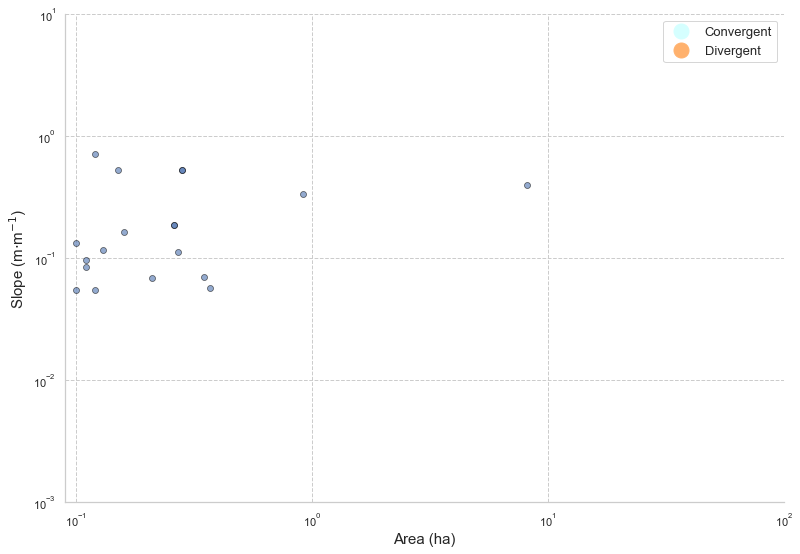

In [359]:
sns.set_style('whitegrid', {'grid.linestyle': '--'})
# baby blue, pale pink
data = data_to_plot
colours = {0:'xkcd:very light blue', 1:'xkcd:pumpkin'}
x_axis = 'area'
y_axis = slope_to_use

fig = sns.relplot(x=x_axis, y=y_axis,  palette = colours, 
                 data=data, alpha = 0.6,  edgecolor='xkcd:black', 
                   markers=['o', 'o'])

ax = fig.axes[0,0]
ax.set_xlim(0.09,100)
ax.set_ylim(0.001,10)
ax.set_xlabel(x_axis, fontsize = 20)
ax.set_ylabel(y_axis, fontsize = 20)
leg = fig._legend
plt.rcParams["axes.edgecolor"] = "0.15"


Div = Line2D([], [], color='xkcd:apricot', marker='o', linestyle='None',
                          markersize=15, label='Divergent')
Conv = Line2D([], [], color='xkcd:very light blue', marker='o', linestyle='None',
                          markersize=15, label='Convergent')

#ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Area (ha)', fontsize = 15)
ax.set_ylabel(('Slope (m$\cdot$m$^{-1}$)'), fontsize = 15)
ax.set(xscale="log", yscale="log")
#ax.set(xscale="log")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize='12')
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title
plt.legend(handles=[Conv, Div],fontsize=13)
fig.fig.set_size_inches(12,8)

In [360]:
untransformed_b, untransformed_k, exponent_b, scalar_k, data_used_by_model = thresholdLineFixedB(data_to_plot, 'area', slope_to_use, 0.4)

In [361]:
untransformed_b, untransformed_k, exponent_b, scalar_k, data_used_by_model = thresholdLineFixedB_r(data_to_plot, 'area', slope_to_use, 0.4)

No handles with labels found to put in legend.


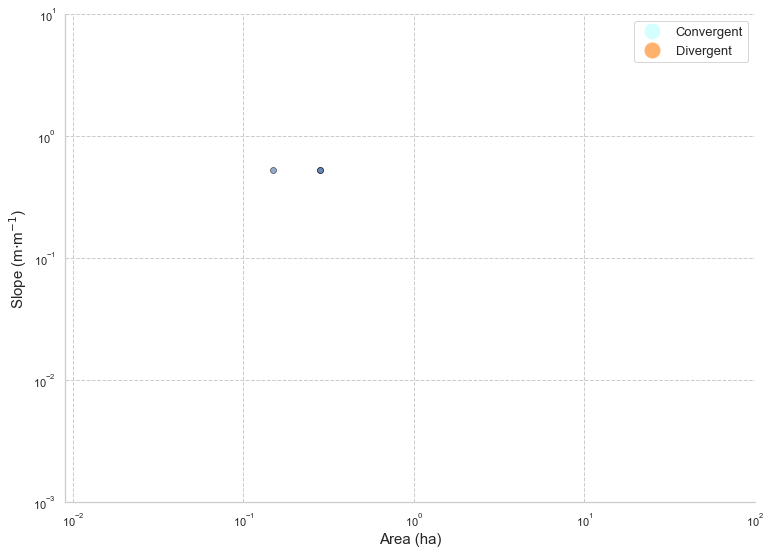

In [362]:
sns.set_style('whitegrid', {'grid.linestyle': '--'})
# baby blue, pale pink
data = data_used_by_model
colours = {0:'xkcd:very light blue', 1:'xkcd:pumpkin'}
x_axis = 'area'
y_axis = slope_to_use

fig = sns.relplot(x=x_axis, y=y_axis,  palette = colours, 
                 data=data, alpha = 0.6,  edgecolor='xkcd:black', 
                   markers=['o', 'o'])

ax = fig.axes[0,0]
ax.set_xlim(0.009,100)
ax.set_ylim(0.001,10)
ax.set_xlabel(x_axis, fontsize = 20)
ax.set_ylabel(y_axis, fontsize = 20)
leg = fig._legend
plt.rcParams["axes.edgecolor"] = "0.15"


Div = Line2D([], [], color='xkcd:apricot', marker='o', linestyle='None',
                          markersize=15, label='Divergent')
Conv = Line2D([], [], color='xkcd:very light blue', marker='o', linestyle='None',
                          markersize=15, label='Convergent')

#ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Area (ha)', fontsize = 15)
ax.set_ylabel(('Slope (m$\cdot$m$^{-1}$)'), fontsize = 15)
ax.set(xscale="log", yscale="log")
#ax.set(xscale="log")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize='12')
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title
plt.legend(handles=[Conv, Div],fontsize=13)
fig.fig.set_size_inches(12,8)

In [363]:
print('b: ', exponent_b)
print('k: ', scalar_k)

b:  0.0138057146594
k:  0.51565248578


In [364]:
orthogonal_regression_dataset = data_used_by_model

In [365]:
# Initiate some data, giving some randomness using random.random().
x = orthogonal_regression_dataset.loc[:,'log_area'].values
y = orthogonal_regression_dataset.loc[:,'log_slope'].values

# Define a function (quadratic in our case) to fit the data with.
def linear_func(p, x):
    m, c = p
    return m*x + c
   
# Create a model for fitting.
linear_model = Model(linear_func)

# Create a RealData object using our initiated data from above.
data = RealData(x, y)

# Set up ODR with the model and data.
odr = ODR(data, linear_model, beta0=[-0.4, -1])

# Run the regression.
out = odr.run()

# Use the in-built pprint method to give us results.
out.pprint()

Beta: [-0.01380571 -0.28764288]
Beta Std Error: [  5.41999478e-30   3.55424487e-30]
Beta Covariance: [[ 20.41823996  13.13291025]
 [ 13.13291025   8.78041933]]
Residual Variance: 1.4387304408468782e-60
Inverse Condition #: 0.08330825319930905
Reason(s) for Halting:
  Parameter convergence


In [366]:
print('b: ', out.beta[0] *-1)
print('k: ', 10**out.beta[1])
b_orth = out.beta[0] 
k_orth = out.beta[1]

b:  0.0138057146594
k:  0.51565248578


In [367]:
k_adjustment_dataset = all_data_plus_right_gh

In [368]:
target_number_of_points_above_line = np.ceil(len(k_adjustment_dataset)*0.95).astype(int)
adjustment = 0
for u in range(0,100):
    above_model_line = []
    for j in k_adjustment_dataset.index:
        measured_slope = k_adjustment_dataset['log_slope'].loc[j]
        adjusted_intercept = k_orth - adjustment
        model_slope = b_orth * k_adjustment_dataset['log_area'].loc[j] + adjusted_intercept
        if  measured_slope > model_slope:
            above_model_line.append(j)                
        else:
            pass
    if len(above_model_line) >= target_number_of_points_above_line:
        break
    else:
        adjustment += 0.01
                

#corrected_set = regression_dataset.drop(above_model_line, axis='index')


In [369]:
exponent_b_to_use = b_orth*-1
scalar_k_to_use = 10**adjusted_intercept

In [370]:
graph_data = all_data_plus_right_gh

In [371]:
model_parameter_k = scalar_k_to_use
model_parameter_b = exponent_b_to_use

In [372]:
generate_area_values = np.arange(0.01, 10, 0.0001)
model_slope = model_parameter_k * (generate_area_values**-model_parameter_b )
df_model_area = pd.DataFrame(generate_area_values)
df_model_area.rename(columns={0: 'area'}, inplace=True)
graph_data['DC'] = 1
reshaped_model_slope = model_slope.reshape(-1,1)
df_model_slope = pd.DataFrame(reshaped_model_slope)
df_model_slope.rename(columns={0: slope_to_use}, inplace=True)
df_model = pd.concat([df_model_slope, df_model_area], axis=1, sort=False)
df_model['DC'] = 3
graph_data['Size'] = 500
df_model['Size'] = 1

df_all_1 = df_model.append(graph_data)

No handles with labels found to put in legend.


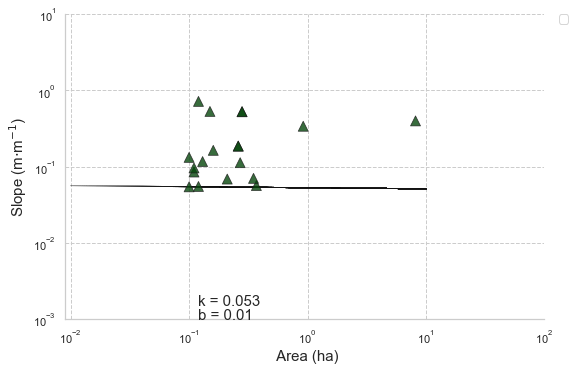

In [373]:
sns.set_style('whitegrid', {'grid.linestyle': '--'})
data = df_all_1
colours = {1:'xkcd:forest green', 3:'xkcd:black', 4:'xkcd:forest green'}
x_axis = 'area'
#x_axis_label = x_axis + ' Area (ha)'
x_axis_label = ' Area (ha)'
y_axis = slope_to_use
fig = sns.relplot(x=x_axis, y=y_axis,  palette = colours, hue = 'DC', 
                 data=data, alpha = 0.8, legend = False, edgecolor="k", 
                  style = 'DC', size = 'Size', sizes = (0.1,100), markers =['^', '.', '.'])

ax = fig.axes[0,0]

ax.set_xlabel(x_axis, fontsize = 20)
ax.set_ylabel(y_axis, fontsize = 20)

fig.set(xlim = (0.009, 100))
fig.set(ylim = (0.001, 10))

leg = fig._legend
plt.rcParams["axes.edgecolor"] = "0.15"

#g1 = Line2D([], [], color='xkcd:orange', marker='s', linestyle='None',
#                          markersize=15, label='Gully head 1 (divergent)')

rs = Line2D([], [], color='xkcd:merlot', marker='^', linestyle='None',
                          markersize=15, label='Random sample (convergent)')

#g2 = Line2D([], [], color='xkcd:scarlet', marker='o', linestyle='None',
#                          markersize=15, label='Gully head 2 (divergent)')

#ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(x_axis_label, fontsize = 15)
ax.set_ylabel(('Slope (m$\cdot$m$^{-1}$)'), fontsize = 15)

plt.legend(bbox_to_anchor=(1.05, 1),  borderaxespad=0.,fontsize='12')
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title
#plt.legend(handles=[rs, g1, g2],fontsize=13, loc=3)
#plt.legend(handles=[rs],fontsize=13, loc=3)

ax.text(0.12, 0.0015,'k = ' + str(np.round(model_parameter_k, 3)), fontsize=15) 
ax.text(0.12, 0.001,'b = ' + str(np.round(model_parameter_b, 2)), fontsize=15)

ax.set_xscale('log')
ax.set_yscale('log')
fig.fig.set_size_inches(8,5)

In [338]:
initial_gully_heads

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [190]:
def np_array_to_Geotiff(newfile, original_tiff, np_array, dtype):
    
    cols = np_array.shape[1]
    rows = np_array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = original_tiff.GetGeoTransform() 
    driver = gdal.GetDriverByName('GTiff')
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Float64": 
        GDT_dtype = gdal.GDT_Float64
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")
    
    if np_array.ndim == 2:
        band_num = 1
    else:
        band_num = np_array.shape[2]

    outRaster = driver.Create(newfile, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    
    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
    
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(np_array)
        else:
            outband.WriteArray(np_array[:,:,b])

    # setteing srs from input tif file.
    prj=original_tiff.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    outRaster = None
    
    return outRaster

In [353]:
np_array_to_Geotiff('norm_10_ghs.tif', input_geotiff, gully_head_node_array, catchment_area.dtype)

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  
